![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Advanced Futures Trading Strategies

"Advanced Futures Trading Strategies" by Robert Carver lays the foundation for building a systematic trading system.

Although the book focuses on futures trading, its concepts are foundational and applicable to other financial instruments.

This notebook replicates the book's initial strategies, emphasizing data processing, metric building, and position size management with risk targeting.

# Data aquisition

In [1]:
from datetime import datetime
from QuantConnect import Resolution
from QuantConnect.Securities import Futures
from QuantConnect.Data.UniverseSelection import *
from helper import calculate_and_merge_returns, summarize_statistics, calculate_contract_risk, simulate_buy_and_hold, calculate_rolling_costs, calculate_combined_std
import numpy as np
from scipy.stats import skew

In [2]:
# Initialize QuantBook
qb = QuantBook()

# Updated Instruments Dictionary
instruments = {
    'ES': { # S&P 500
        'multiplier': 50,
        'tick_value': 0.25,
        'minimum_fluctuation': 12.50,
        'spread': 0.25, # diferencia entre bid y ask
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Indices.SP500EMini,
        'resolution': Resolution.Daily,
        'sector': 'equity',
        'subsector': 'us',
        'multiply_close': False # Ajuste manual que tengo que hacer para algunos instrumentos
    },
    'MES': {
        'multiplier': 5,
        'tick_value': 0.25,
        'minimum_fluctuation': 1.25,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Indices.MicroSP500EMini,
        'resolution': Resolution.Daily,
        'sector': 'equity',
        'subsector': 'us',
        'multiply_close': False
    },
    'ZN': {     # 10-Year Treasury
        'multiplier': 1000,
        'tick_value': 0.015625,
        'minimum_fluctuation': 15.625,
        'spread': 0.015625,
        'commission': 2.50,
        'rolling_months': [6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Financials.Y10TreasuryNote,
        'resolution': Resolution.Daily,
        'sector': 'bonds',
        'subsector': 'long_term',
        'multiply_close': False
    },
    'ZF': {  # 5-Year Treasury
        'multiplier': 1000,
        'tick_value': 0.0078125,
        'minimum_fluctuation': 7.8125,
        'spread': 0.0078125,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Financials.Y5TreasuryNote,
        'resolution': Resolution.Daily,
        'sector': 'bonds',
        'subsector': 'short_term',
        'multiply_close': False
    },
    'ZB': {  # 30-Year Treasury
        'multiplier': 1000,
        'tick_value': 0.03125,
        'minimum_fluctuation': 31.25,
        'spread': 0.03125,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Financials.Y30TreasuryBond,
        'resolution': Resolution.Daily,
        'sector': 'bonds',
        'subsector': 'medium_term',
        'multiply_close': False
    },
    'ZW': {  # Wheat
        'multiplier': 5000,
        'tick_value': 0.25,
        'minimum_fluctuation': 1250,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Grains.SRWWheat,
        'resolution': Resolution.Daily,
        'sector': 'agriculture',
        'subsector': 'grains',
        'multiply_close': True
    },
    'CL': {  # Crude Oil
        'multiplier': 1000,
        'tick_value': 0.01,
        'minimum_fluctuation': 10.00,
        'spread': 0.01,
        'commission': 2.50,
        'rolling_months': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Energies.CrudeOilWTI,
        'resolution': Resolution.Daily,
        'sector': 'energy',
        'subsector': 'fossil',
        'multiply_close': False
    },
    'GC': {  # Gold
        'multiplier': 100,
        'tick_value': 0.1,
        'minimum_fluctuation': 10.00,
        'spread': 0.1,
        'commission': 2.50,
        'rolling_months': [2, 4, 6, 8, 10, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.Gold,
        'resolution': Resolution.Daily,
        'sector': 'metals',
        'subsector': 'precious',
        'multiply_close': False
    },
    'HE': {  # Lean Hog
        'multiplier': 40000,
        'tick_value': 0.025,
        'minimum_fluctuation': 1000,
        'spread': 0.025,
        'commission': 2.50,
        'rolling_months': [2, 4, 6, 7, 8, 10, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Meats.LeanHogs,
        'resolution': Resolution.Daily,
        'sector': 'livestock',
        'subsector': 'hogs',
        'multiply_close': True
    },
    'GF': {  # Feeder Cattle
        'multiplier': 50000,
        'tick_value': 0.025,
        'minimum_fluctuation': 1250,
        'spread': 0.025,
        'commission': 2.50,
        'rolling_months': [1, 3, 4, 5, 8, 9, 10, 11],
        'subscription_type': 'Future',
        'subscription_details': Futures.Meats.FeederCattle,
        'resolution': Resolution.Daily,
        'sector': 'livestock',
        'subsector': 'cattle',
        'multiply_close': True
    },
    'ZS': {  # Soy Bean
        'multiplier': 5000,
        'tick_value': 0.25,
        'minimum_fluctuation': 1250,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [1, 3, 5, 7, 8, 9, 11],
        'subscription_type': 'Future',
        'subscription_details': Futures.Grains.Soybeans,
        'resolution': Resolution.Daily,
        'sector': 'agriculture',
        'subsector': 'grains',
        'multiply_close': True
    },
    'ZC': {  # Corn
        'multiplier': 5000,
        'tick_value': 0.25,
        'minimum_fluctuation': 1250,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Grains.Corn,
        'resolution': Resolution.Daily,
        'sector': 'agriculture',
        'subsector': 'grains',
        'multiply_close': True
    },
    'NG': {  # Natural Gas
        'multiplier': 10000,
        'tick_value': 0.001,
        'minimum_fluctuation': 10.00,
        'spread': 0.001,
        'commission': 2.50,
        'rolling_months': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Energies.NaturalGas,
        'resolution': Resolution.Daily,
        'sector': 'energy',
        'subsector': 'fossil',
        'multiply_close': False
    },
    'SI': {  # Silver
        'multiplier': 5000,
        'tick_value': 0.005,
        'minimum_fluctuation': 25.00,
        'spread': 0.005,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.Silver,
        'resolution': Resolution.Daily,
        'sector': 'metals',
        'subsector': 'precious',
        'multiply_close': False
    },
    'HG': {  # Copper
        'multiplier': 25000,
        'tick_value': 0.0005,
        'minimum_fluctuation': 12.50,
        'spread': 0.0005,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.Copper,
        'resolution': Resolution.Daily,
        'sector': 'metals',
        'subsector': 'industrial',
        'multiply_close': False
    },
    'NQ': {  # Nasdaq
        'multiplier': 20,
        'tick_value': 0.25,
        'minimum_fluctuation': 5.00,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Indices.NASDAQ100EMini,
        'resolution': Resolution.Daily,
        'sector': 'equity',
        'subsector': 'us',
        'multiply_close': False
    },
    '6E': {  # Euro FX
        'multiplier': 125000,
        'tick_value': 0.00005,
        'minimum_fluctuation': 6.25,
        'spread': 0.00005,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Currencies.EUR,
        'resolution': Resolution.Daily,
        'sector': 'currency',
        'subsector': 'major',
        'multiply_close': False
    },
    '6J': {  # Japanese Yen
        'multiplier': 12500000,
        'tick_value': 0.0000005,
        'minimum_fluctuation': 6.25,
        'spread': 0.0000005,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Currencies.JPY,
        'resolution': Resolution.Daily,
        'sector': 'currency',
        'subsector': 'major',
        'multiply_close': False
    },
    '6B': {  # British Pound
        'multiplier': 62500,
        'tick_value': 0.0001,
        'minimum_fluctuation': 6.25,
        'spread': 0.0001,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Currencies.GBP,
        'resolution': Resolution.Daily,
        'sector': 'currency',
        'subsector': 'major',
        'multiply_close': False
    },
    'VIX': {  # CBOE Volatility Index
        'multiplier': 1000,
        'tick_value': 0.005,
        'minimum_fluctuation': 5.00,
        'spread': 0.005,
        'commission': 2.50,
        'rolling_months': [1, 2, 3, 4, 5, 6, 7, 8],
        'subscription_type': 'Future',
        'subscription_details': Futures.Indices.VIX,
        'resolution': Resolution.Daily,
        'sector': 'volatility',
        'subsector': 'index',
        'multiply_close': False
    },
    'TN': {  # Ultra 10-Year U.S. Treasury Note
        'multiplier': 1000,
        'tick_value': 0.015625,
        'minimum_fluctuation': 15.625,
        'spread': 0.015625,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Financials.ULTRA_TEN_YEAR_US_TREASURY_NOTE,
        'resolution': Resolution.Daily,
        'sector': 'bonds',
        'subsector': 'long_term',
        'multiply_close': False
    },
    'NKD': {  # Nikkei-225 Dollar
        'multiplier': 5,
        'tick_value': 5,
        'minimum_fluctuation': 25.00,
        'spread': 5,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Indices.NIKKEI_225_DOLLAR,
        'resolution': Resolution.Daily,
        'sector': 'equity',
        'subsector': 'international',
        'multiply_close': False
    },
    'LBR': {  # Lumber (corregido de LBS)
        'multiplier': 27.5,
        'tick_value': 0.5,
        'minimum_fluctuation': 13.75,
        'spread': 0.5,
        'commission': 2.50,
        'rolling_months': [1, 3, 5, 7, 9, 11],
        'subscription_type': 'Future',
        'subscription_details': Futures.Forestry.LUMBER,
        'resolution': Resolution.Daily,
        'sector': 'agriculture',
        'subsector': 'lumber',
        'multiply_close': False
    },
    'AUP': {  # Aluminum MW U.S. Transaction Premium
        'multiplier': 55116,
        'tick_value': 0.00001,
        'minimum_fluctuation': 0.55116,
        'spread': 0.00001,
        'commission': 2.50,
        'rolling_months': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.ALUMINUM_MWUS_TRANSACTION_PREMIUM_PLATTS_25_MT,
        'resolution': Resolution.Daily,
        'sector': 'metals',
        'subsector': 'industrial',
        'multiply_close': False
    },
    'ZL': {  # Soybean Oil
        'multiplier': 60000,
        'tick_value': 0.01,
        'minimum_fluctuation': 600,
        'spread': 0.01,
        'commission': 2.50,
        'rolling_months': [1, 3, 5, 7, 8, 9, 10, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Grains.SOYBEAN_OIL,
        'resolution': Resolution.Daily,
        'sector': 'agriculture',
        'subsector': 'grains',
        'multiply_close': True
    },
    'ZO': {  # Oats
        'multiplier': 5000,
        'tick_value': 0.25,
        'minimum_fluctuation': 1250,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Grains.OATS,
        'resolution': Resolution.Daily,
        'sector': 'agriculture',
        'subsector': 'grains',
        'multiply_close': True
    },
    'LE': {  # Live Cattle
        'multiplier': 40000,
        'tick_value': 0.025,
        'minimum_fluctuation': 1000,
        'spread': 0.025,
        'commission': 2.50,
        'rolling_months': [2, 4, 6, 8, 10, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Meats.LIVE_CATTLE,
        'resolution': Resolution.Daily,
        'sector': 'livestock',
        'subsector': 'cattle',
        'multiply_close': True
    },
    'USDMXN': { #forex exchange rate to mxn
        'subscription_type': 'Forex',
        'subscription_details': 'USDMXN',
        'resolution': Resolution.Daily,
        'multiplier': 1,
        'multiply_close': False
    }
}


In [3]:
from datetime import datetime

# Add Subscriptions for Futures and Forex
subscriptions = {}
for symbol, details in instruments.items():
    if details['subscription_type'] == 'Future':
        future = qb.AddFuture(details['subscription_details'], details['resolution'])
        subscriptions[symbol] = future.Symbol
    elif details['subscription_type'] == 'Forex':
        forex = qb.AddForex(details['subscription_details'], details['resolution'])
        subscriptions[symbol] = forex.Symbol

# Set Historical Data Range
general_start_date = datetime(2007, 1, 1)
specific_start_date = datetime(2013, 1, 1)  # Fecha específica para SI
end_date = datetime.now()
trading_days_per_year = 256
capital = 100000
target_risk = .20

# Request Historical Data
timeseries = {}
for symbol, sub_symbol in subscriptions.items():
    start_date = specific_start_date if symbol == 'SI' else general_start_date
    history = qb.History([sub_symbol], start_date, end_date, instruments[symbol]['resolution'])
    if 'close' in history.columns and 'volume' in history.columns:
        if instruments[symbol]['subscription_type'] == 'Future':
            history.reset_index(level=0, drop=True, inplace=True)
        if instruments[symbol]['multiply_close']:
            history['close'] *= 100
        timeseries[symbol] = history[['close', 'volume']]
    else:
        print(f"No 'close' or 'volume' column found for {symbol}")

# Clean up
del details
del end_date
del future
del forex
del history
del general_start_date
del specific_start_date
del sub_symbol
del symbol



No 'close' or 'volume' column found for USDMXN


In [4]:

# Subscribe to USDMXN forex pair
usdmxn = qb.AddForex("USDMXN", Resolution.Daily).Symbol

# Retrieve historical data
history = qb.History([usdmxn], 365, Resolution.Daily)

# Ensure the 'close' data is correctly extracted from the history DataFrame
fx_data = history.loc[usdmxn][['close']]

del history
del usdmxn

## Print the timeseries

In [5]:
#Print symbols and first 5 entires of historical_data
for symbol, data in timeseries.items():
    print(symbol)
    print(data.tail())


ES
                              close     volume
symbol time                                   
ES 1S1 2024-06-28 20:00:00  5532.25  1497621.0
       2024-07-01 20:00:00  5532.00  1153785.0
       2024-07-02 20:00:00  5562.75  1043401.0
       2024-07-03 20:00:00  5591.00   580493.0
       2024-07-04 20:00:00  5591.00        0.0
MES
                               close    volume
symbol  time                                  
MES 1S1 2024-06-28 20:00:00  5533.00  886223.0
        2024-07-01 20:00:00  5532.25  719088.0
        2024-07-02 20:00:00  5562.25  665460.0
        2024-07-03 20:00:00  5590.50  357071.0
        2024-07-04 20:00:00  5590.50       0.0
ZN
                                 close     volume
symbol time                                      
ZN MD  2024-06-27 19:00:00  110.265625   957328.0
       2024-06-28 19:00:00  109.640625  2182679.0
       2024-07-01 19:00:00  109.265625  1179035.0
       2024-07-02 19:00:00  109.453125   967706.0
       2024-07-03 19:00:00  109.

In [6]:
# Print timeseries' index
print(timeseries['ES'].index)

# Print timeseries' column names
print(timeseries['ES'].columns)


MultiIndex([('ES 1S1', '2007-01-03 19:00:00'),
            ('ES 1S1', '2007-01-04 19:00:00'),
            ('ES 1S1', '2007-01-05 19:00:00'),
            ('ES 1S1', '2007-01-08 19:00:00'),
            ('ES 1S1', '2007-01-09 19:00:00'),
            ('ES 1S1', '2007-01-10 19:00:00'),
            ('ES 1S1', '2007-01-11 19:00:00'),
            ('ES 1S1', '2007-01-12 19:00:00'),
            ('ES 1S1', '2007-01-16 19:00:00'),
            ('ES 1S1', '2007-01-17 19:00:00'),
            ...
            ('ES 1S1', '2024-06-21 20:00:00'),
            ('ES 1S1', '2024-06-24 20:00:00'),
            ('ES 1S1', '2024-06-25 20:00:00'),
            ('ES 1S1', '2024-06-26 20:00:00'),
            ('ES 1S1', '2024-06-27 20:00:00'),
            ('ES 1S1', '2024-06-28 20:00:00'),
            ('ES 1S1', '2024-07-01 20:00:00'),
            ('ES 1S1', '2024-07-02 20:00:00'),
            ('ES 1S1', '2024-07-03 20:00:00'),
            ('ES 1S1', '2024-07-04 20:00:00')],
           names=['symbol', 'time'], length

## Individual dataframe creation

In [7]:

for symbol, data in timeseries.items():
    globals()[symbol] = pd.DataFrame(data)

## Summary statistics
We can begin working with the aquired data to calculate some useful statistics, such as returns, standard deviations, skew and fat tail ratios. Use the helper function to process these statistics.

### Returns Time Series

In [8]:
# Creación de returns series

for symbol, price_df in timeseries.items():
    price_series = price_df['close']
    volume_series = price_df['volume']
    merged_df = calculate_and_merge_returns(symbol, price_series, volume_series, instruments)
    timeseries[symbol] = merged_df.loc[:, ['close', 'volume', 'price_return', 'currency_return', 'percentage_return']]

del price_df, price_series, volume_series, merged_df



### Summary Stats for each symbol
mean_return, std_dev, annualized_mean, annualized_std_dev, daily_sharpe_ratio, annualized_sharpe_ratio

In [9]:
summary = summarize_statistics(timeseries, trading_days_per_year)


In [10]:
print("Summary Statistics for Each Symbol:")

for symbol, stats in summary.items():
    print(f"{symbol}:")
    print(summary[symbol])


Summary Statistics for Each Symbol:
ES:
{'mean_return': 0.038592192020893534, 'std_dev': 1.2469171629540303, 'annualized_mean': 10.382006801734512, 'annualized_std_dev': 19.950674607264485, 'daily_sharpe_ratio': 0.03095008487128852, 'annualized_sharpe_ratio': 0.4952013579406163, 'monthly_skew': -14.420997661545947, 'lower_fat_tail_ratio': 2.5662938007859326, 'higher_fat_tail_ratio': 1.7477443314896501}
MES:
{'mean_return': 0.05301639204710344, 'std_dev': 1.2891451294381682, 'annualized_mean': 14.53222047027456, 'annualized_std_dev': 20.62632207101069, 'daily_sharpe_ratio': 0.04112523162555709, 'annualized_sharpe_ratio': 0.6580037060089134, 'monthly_skew': -7.747007747011122, 'lower_fat_tail_ratio': 2.1688829469572215, 'higher_fat_tail_ratio': 1.427880241466343}
ZN:
{'mean_return': 0.008310275695110834, 'std_dev': 0.3846005486642268, 'annualized_mean': 2.1501314238389524, 'annualized_std_dev': 6.153608778627629, 'daily_sharpe_ratio': 0.021607550285545927, 'annualized_sharpe_ratio': 0.34

## Backtest buy and hold 1 contract.

In [11]:
 # Rolling costs per instrument. uncomment to compute

 rolling_costs_per_instrument = {}

 for symbol, data in timeseries.items():
     instrument_details = instruments[symbol]
     rolling_costs = calculate_rolling_costs(instrument_details, data)
     rolling_costs_per_instrument[symbol] = rolling_costs

 print(rolling_costs_per_instrument)


{'ES': 1225.0, 'MES': 131.25, 'ZN': 1072.5, 'ZF': 896.875, 'ZB': 2537.5, 'ZW': 110440.0, 'CL': 3165.0, 'GC': 1050.0, 'HE': 123615.0, 'GF': 175700.0, 'ZS': 154365.0, 'ZC': 110440.0, 'NG': 3165.0, 'SI': 1740.0, 'HG': 1172.5, 'NQ': 700.0, '6E': 787.5, '6J': 787.5, '6B': 787.5, 'VIX': 1110.0, 'TN': 1134.375, 'NKD': 2100.0, 'LBR': 112.5, 'AUP': 771.6112399999986, 'ZL': 84700.0, 'ZO': 110440.0, 'LE': 105525.0}


In [12]:
# Your existing simulation code
buyhold_results = {}

for symbol, data in timeseries.items():
    print(f"Symbol: {symbol}, Start Date: {data.index[0][1]}, End Date: {data.index[-1][1]}")
    instrument_details = instruments[symbol]
        
    num_contracts = 1  # Specify the number of contracts as needed
    
    bnh_return, bnh_return_mxn = simulate_buy_and_hold(data, instrument_details, fx_data, num_contracts)
    buyhold_results[symbol] = {
        'bnh_return': bnh_return,
        'bnh_return_mxn': bnh_return_mxn
    }
print(buyhold_results)

Symbol: ES, Start Date: 2007-01-04 19:00:00, End Date: 2024-07-04 20:00:00
Symbol: MES, Start Date: 2019-05-07 20:00:00, End Date: 2024-07-04 20:00:00
Symbol: ZN, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-03 19:00:00
Symbol: ZF, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-03 19:00:00
Symbol: ZB, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-03 19:00:00
Symbol: ZW, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-03 19:00:00
Symbol: CL, Start Date: 2007-01-04 19:00:00, End Date: 2024-07-03 20:00:00
Symbol: GC, Start Date: 2012-11-01 20:00:00, End Date: 2024-07-03 20:00:00
Symbol: HE, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-03 19:00:00
Symbol: GF, Start Date: 2007-01-09 18:00:00, End Date: 2024-07-03 19:00:00
Symbol: ZS, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-03 19:00:00
Symbol: ZC, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-03 19:00:00
Symbol: NG, Start Date: 2007-01-04 19:00:00, End Date: 2024-07-03 20:00:00
Symbol: SI, Start Date: 

# Strategy 2: Risk measurement, risk target and capital


## Contract risk in base currency

Update summary dictionary to include the daily and annual contract risk 

risk in currency terms = notional exposure * std dev

notional exposure = last closing price * multiplier

compute number of instruments to achieve target risk given a static risk 

In [13]:
# Update summary with contract risks

summary = calculate_contract_risk(summary, instruments, timeseries)
print("Summary Statistics for Each Symbol with Contract Risks:")
for symbol, stats in summary.items():
    print(f"{symbol}:")
    print(summary[symbol])

Summary Statistics for Each Symbol with Contract Risks:
ES:
{'mean_return': 0.038592192020893534, 'std_dev': 1.2469171629540303, 'annualized_mean': 10.382006801734512, 'annualized_std_dev': 19.950674607264485, 'daily_sharpe_ratio': 0.03095008487128852, 'annualized_sharpe_ratio': 0.4952013579406163, 'monthly_skew': -14.420997661545947, 'lower_fat_tail_ratio': 2.5662938007859326, 'higher_fat_tail_ratio': 1.7477443314896501, 'daily_contract_risk': 3485.7569290379915, 'annualized_contract_risk': 55772.110864607865}
MES:
{'mean_return': 0.05301639204710344, 'std_dev': 1.2891451294381682, 'annualized_mean': 14.53222047027456, 'annualized_std_dev': 20.62632207101069, 'daily_sharpe_ratio': 0.04112523162555709, 'annualized_sharpe_ratio': 0.6580037060089134, 'monthly_skew': -7.747007747011122, 'lower_fat_tail_ratio': 2.1688829469572215, 'higher_fat_tail_ratio': 1.427880241466343, 'daily_contract_risk': 360.348292306204, 'annualized_contract_risk': 5765.572676899264}
ZN:
{'mean_return': 0.0083102

In [14]:
# Compute target risk in currency
target_risk_in_usd = capital * target_risk

# Compute position size
def calculate_position_size(target_risk_in_usd, contract_risk, capital):
    return target_risk_in_usd / contract_risk

In [15]:
# Calculate position size for each symbol
position_sizes = {}
for symbol, stats in summary.items():
    position_size = calculate_position_size(target_risk_in_usd, stats['annualized_contract_risk'], capital)
    position_sizes[symbol] = position_size
# Print position sizes
print ("Position sizes to achieve target risk per instrument:")
for symbol, position_size in position_sizes.items():
    print(f"{symbol}: {position_size}")


Position sizes to achieve target risk per instrument:
ES: 0.3586021703311878
MES: 3.468866168339767
ZN: 2.956339164182546
ZF: 1.2793852899657543
ZB: 1.5368312897898995
ZW: 0.02112870731397735
CL: 0.5880304768404543
GC: 0.5529581421362917
HE: 0.019888168240696582
GF: 0.009036294712564064
ZS: 0.01471262199543307
ZC: 0.034159905510898446
NG: 1.6971204848166506
SI: 0.466235417748232
HG: 0.787381340405434
NQ: 0.218443149603559
6E: 1.6296724682302575
6J: 0.0020008760611347864
6B: 2.6024351357400795
VIX: 1.827034710805797
TN: 1.7070865829578503
NKD: 0.4035373184399276
LBR: 7.510435382337027
AUP: 0.11318761624762641
ZL: 0.027383081768238168
ZO: 0.03966957477748925
LE: 0.017137785042706046


# Strategy 3, rolling windows and combined long and short term risk metric

In [16]:
# Calcular la desviación estándar combinada y agregarla a timeseries
returns_std = calculate_combined_std(timeseries)
for symbol, std_series in returns_std.items():
    timeseries[symbol]['combined_std'] = std_series


### El tamaño de la posición se calcula correctamente, continuamos con la implementación del backtest

## Strat 3 backtest

Strat 3 backtest 01/07/2024

In [17]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict

def strategy_3(timeseries, instruments, capital_initial, target_risk=0.20):
    """
    Implements a financial trading strategy based on risk-adjusted position sizing.
    
    :param timeseries: Dict of DataFrames containing time series data for each instrument
    :param instruments: Dict containing instrument-specific information (e.g., multiplier)
    :param capital_initial: Initial capital for the strategy
    :param target_risk: Target risk as a fraction of capital (default: 20%)
    :return: DataFrame of results, dict of average round trips, dict of position logs
    """
    results = []
    yearly_round_trips = defaultdict(lambda: defaultdict(int))
    position_logs = {symbol: [] for symbol in timeseries.keys()}
    contracts_opened = {symbol: 0 for symbol in timeseries.keys()}
    
    for symbol, data in timeseries.items():
        # Add day of week if not present
        if 'day_of_week' not in data.columns:
            data['day_of_week'] = data.index.get_level_values('time').map(lambda x: x.weekday())

        capital = capital_initial
        max_capital = capital
        prev_positions = 0
        last_friday_position = 0
        sample_count = 0
        multiplier = instruments[symbol]['multiplier']

        for idx, row in data.iterrows():
            current_year = idx[1].year
            sample_count += 1
            
            # Calculate target risk and position size
            target_risk_in_usd = capital * target_risk
            contract_risk_currency = row['combined_std'] * row['close'] * multiplier
            position_size_float = target_risk_in_usd / contract_risk_currency if contract_risk_currency > 0 else 0
            new_position = np.round(position_size_float)

            # Warm-up period: first 40 samples
            if sample_count <= 40:
                results.append({
                    'time': idx[1], 'symbol': symbol, 'position_size': 0, 'position_size_float': 0,
                    'capital': capital, 'drawdown': max_capital - capital,
                    'target_risk_in_usd': 0, 'combined_std': row['combined_std'],
                    'contract_risk_currency': contract_risk_currency,
                    'currency_return': row['currency_return'], 'close_price': row['close']
                })
                continue

            # Store Friday's position for Monday's trading
            if row['day_of_week'] == 4:  # Friday
                last_friday_position = new_position
            
            # Adjust positions on Monday based on Friday's calculation
            if row['day_of_week'] == 0 and last_friday_position is not None:  # Monday
                position_change = new_position - prev_positions
                if position_change > 0:
                    # Opened new contracts
                    contracts_opened[symbol] += position_change
                    position_logs[symbol].append(f"Opened {position_change} contracts on {idx[1]}: Total position {new_position}")
                elif position_change < 0:
                    # Closed contracts
                    closed_contracts = min(abs(position_change), contracts_opened[symbol])
                    yearly_round_trips[symbol][current_year] += closed_contracts
                    contracts_opened[symbol] -= closed_contracts
                    position_logs[symbol].append(f"Closed {closed_contracts} contracts on {idx[1]}: Total position {new_position}, Yearly round trips {yearly_round_trips[symbol][current_year]}")

                prev_positions = new_position

            # Calculate daily return and update capital
            daily_return = row['currency_return'] * prev_positions
            capital += daily_return
            max_capital = max(max_capital, capital)
            drawdown = max_capital - capital
            
            # Store results for this iteration
            results.append({
                'time': idx[1], 'symbol': symbol, 'position_size': prev_positions, 'position_size_float': position_size_float,
                'capital': capital, 'drawdown': drawdown,
                'target_risk_in_usd': target_risk_in_usd, 'combined_std': row['combined_std'],
                'contract_risk_currency': contract_risk_currency,
                'currency_return': row['currency_return'], 'close_price': row['close']
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate average round trips per year
    avg_round_trips = {}
    for symbol, yearly_trips in yearly_round_trips.items():
        total_trips = sum(yearly_trips.values())
        num_years = len(yearly_trips)
        avg_round_trips[symbol] = total_trips / num_years if num_years > 0 else 0

    return results_df, avg_round_trips, position_logs

# Define backtest parameters and execute
capital_initial = 100000
results, avg_round_trips, position_logs = strategy_3(timeseries, instruments, capital_initial)

# Print results
print("Global backtest results:")
print(results.tail())
print("\nAverage round trips per year:")
print(avg_round_trips)

# Print detailed logs for ES and MES
print("\nDetailed position logs for ES:")
print("\n".join(position_logs['ES'][:10]))  # Print first 10 log entries
print("\nDetailed position logs for MES:")
print("\n".join(position_logs['MES'][:10]))  # Print first 10 log entries

Global backtest results:
                      time symbol  position_size  position_size_float  \
104817 2024-06-27 19:00:00     LE            0.0             0.022469   
104818 2024-06-28 19:00:00     LE            0.0             0.022905   
104819 2024-07-01 19:00:00     LE            0.0             0.023423   
104820 2024-07-02 19:00:00     LE            0.0             0.023683   
104821 2024-07-03 19:00:00     LE            0.0             0.023840   

         capital  drawdown  target_risk_in_usd  combined_std  \
104817  100000.0       0.0             20000.0      0.119160   
104818  100000.0       0.0             20000.0      0.117819   
104819  100000.0       0.0             20000.0      0.115840   
104820  100000.0       0.0             20000.0      0.114087   
104821  100000.0       0.0             20000.0      0.112776   

        contract_risk_currency  currency_return  close_price  
104817           890123.710384           3000.0      186.750  
104818           873154.3

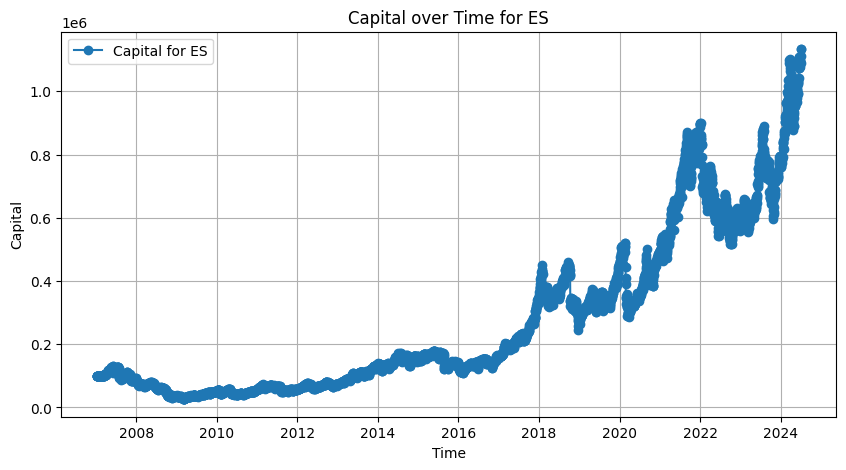

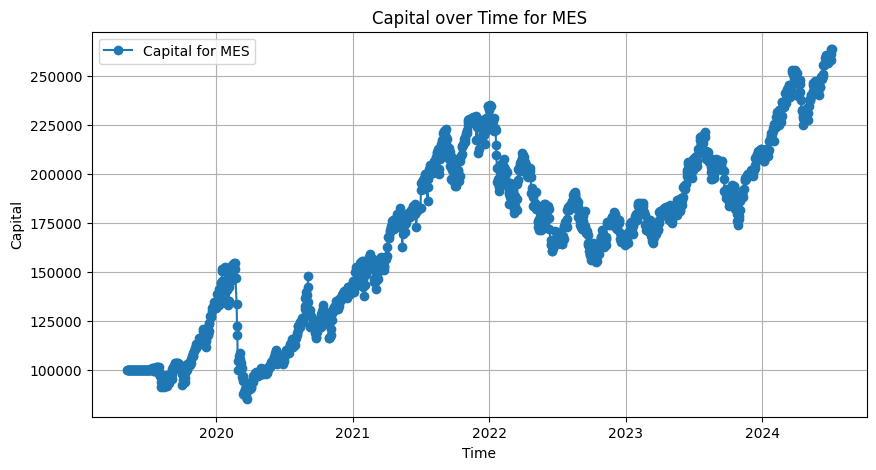

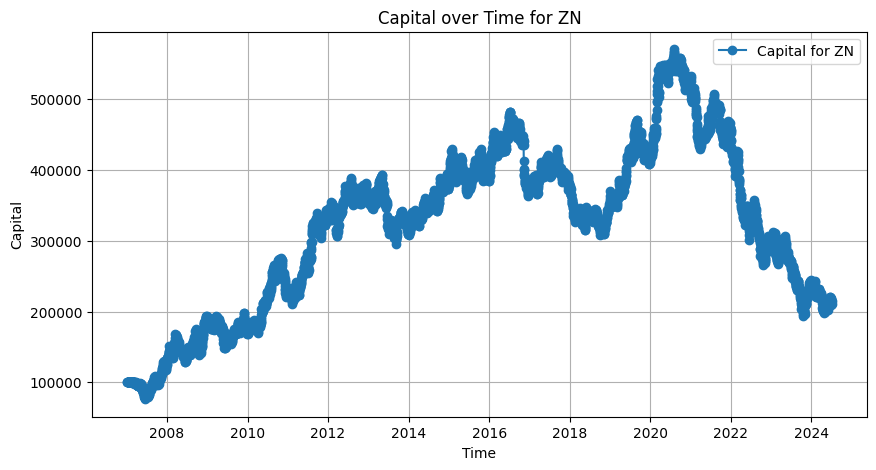

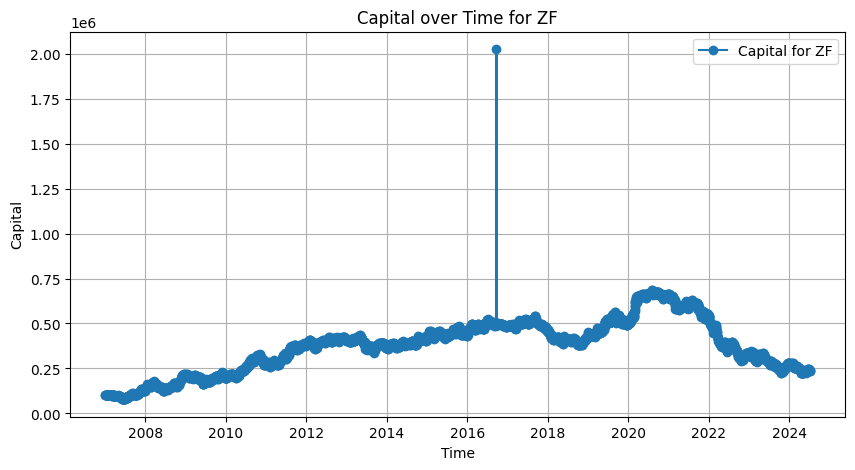

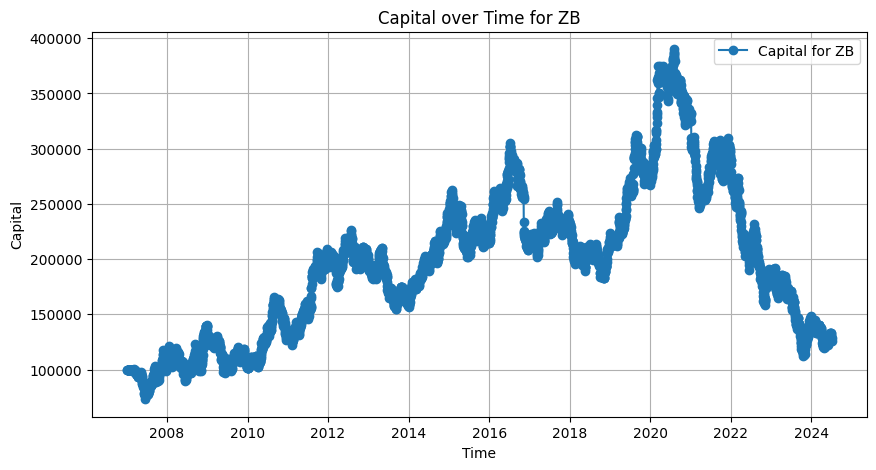

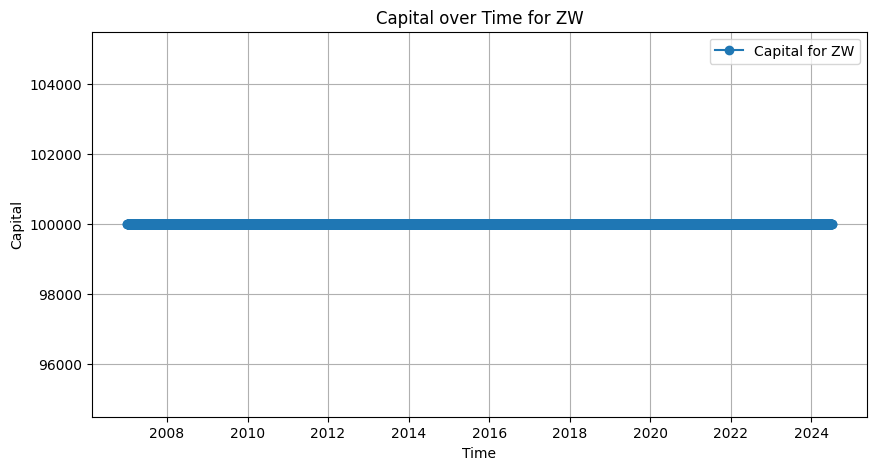

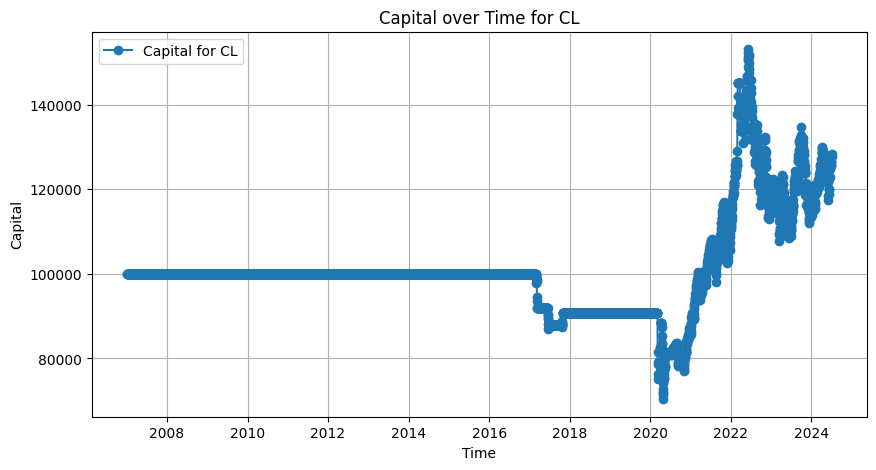

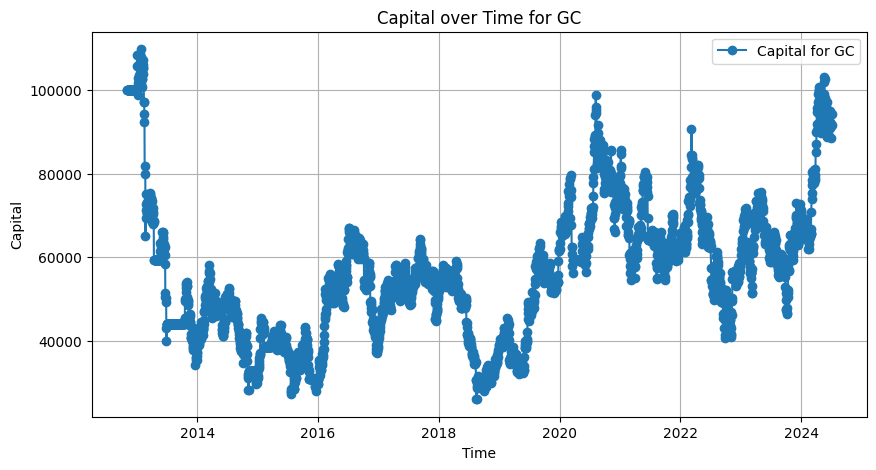

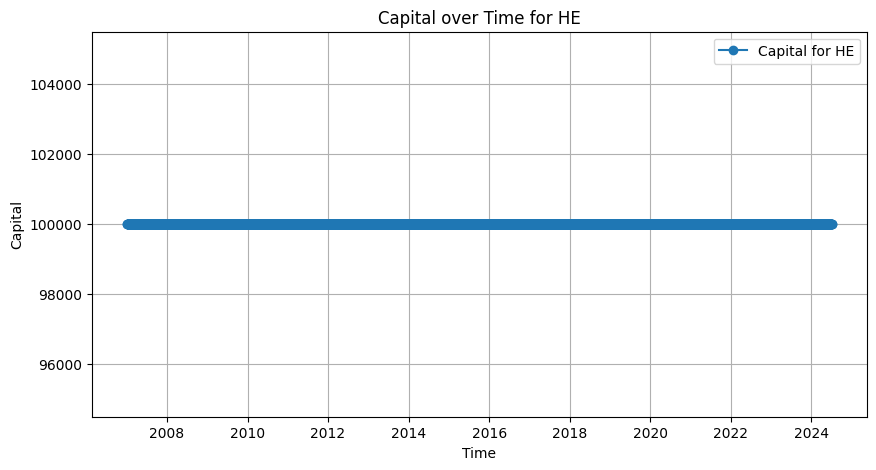

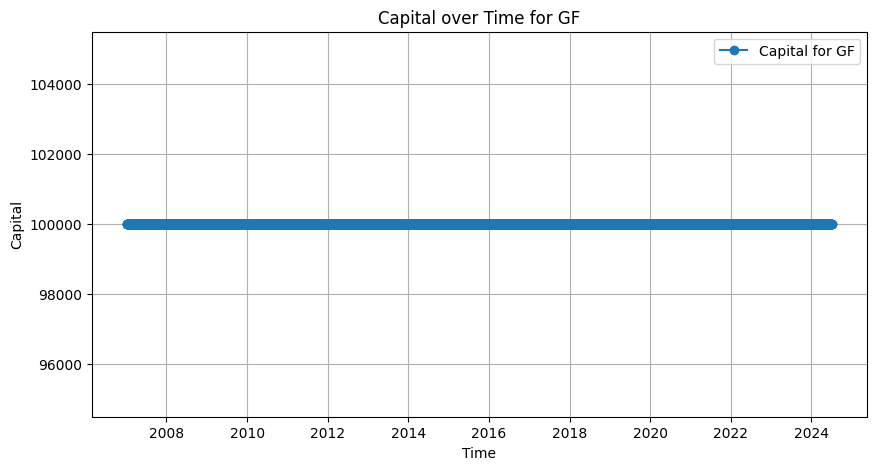

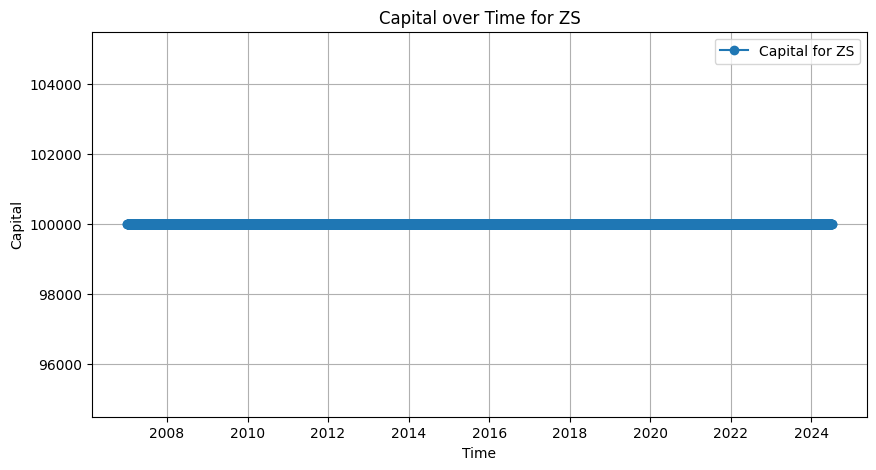

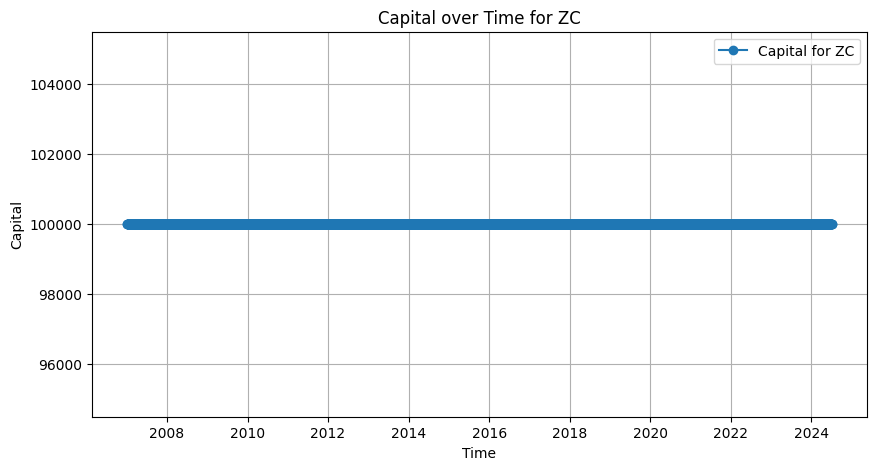

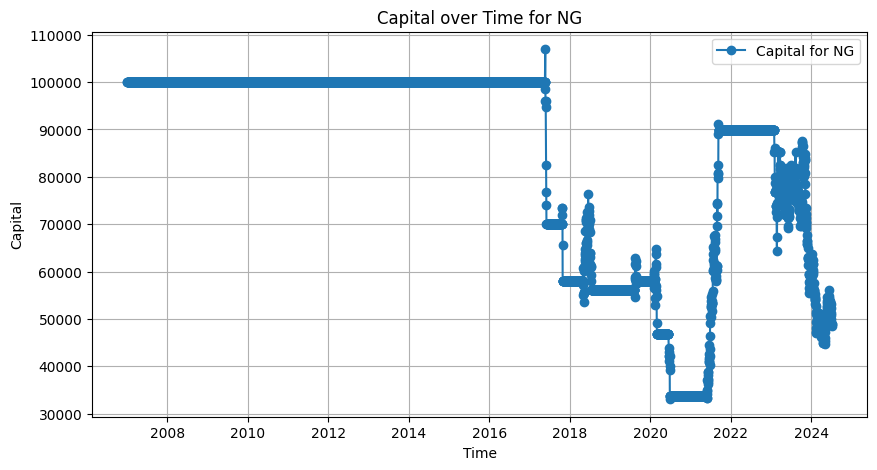

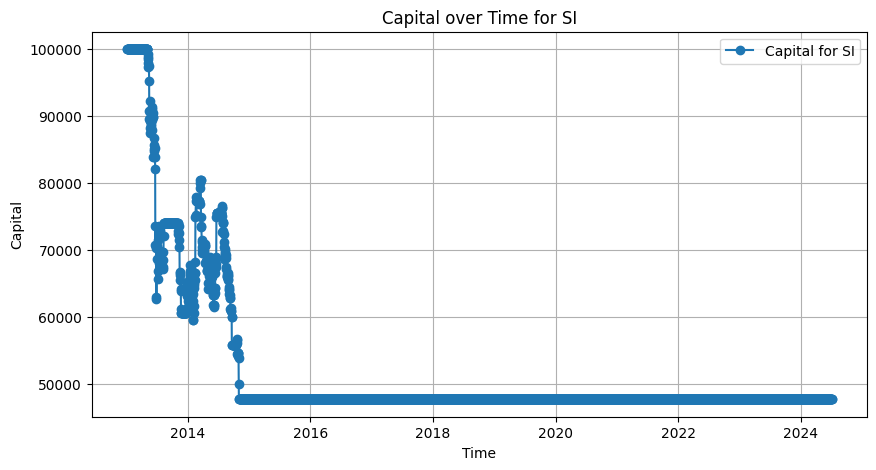

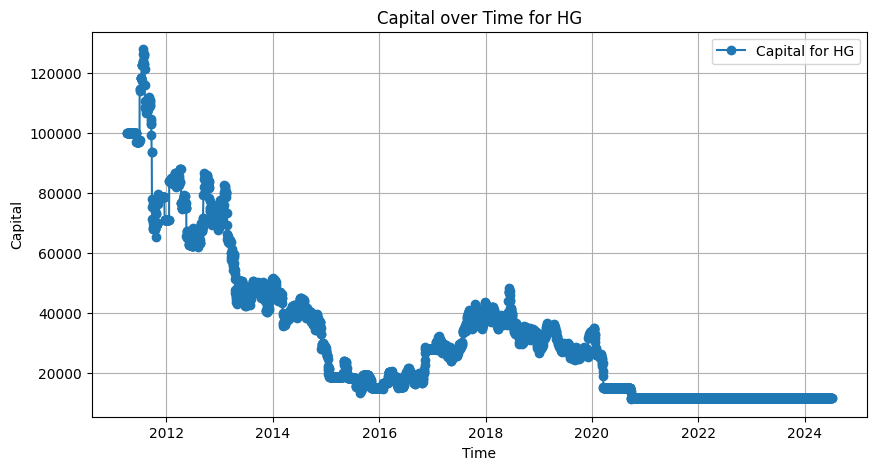

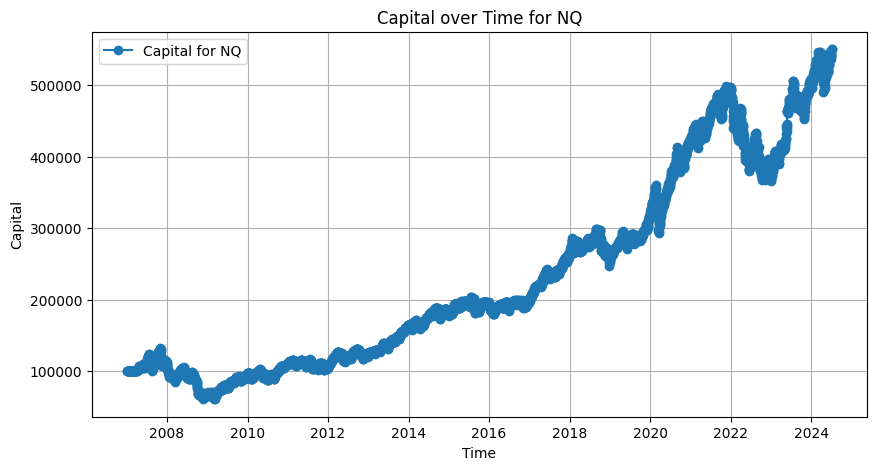

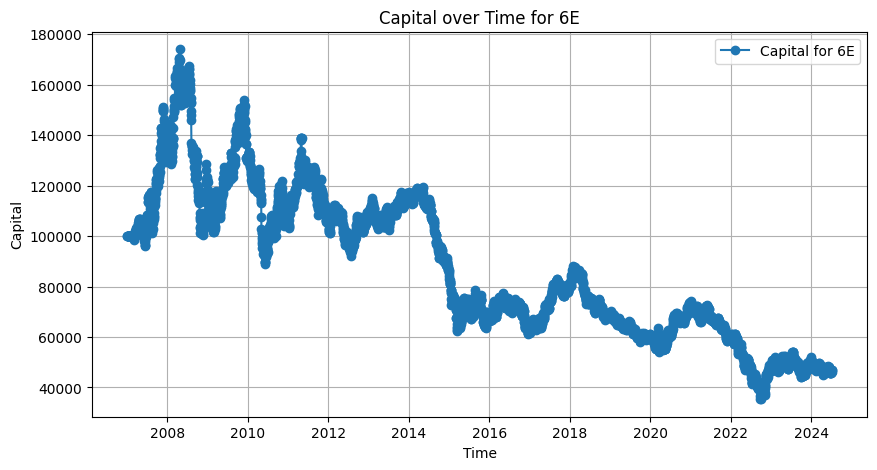

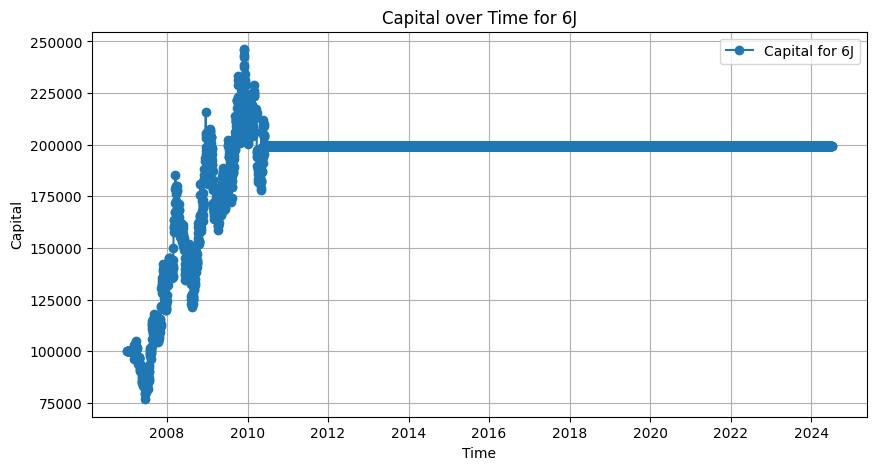

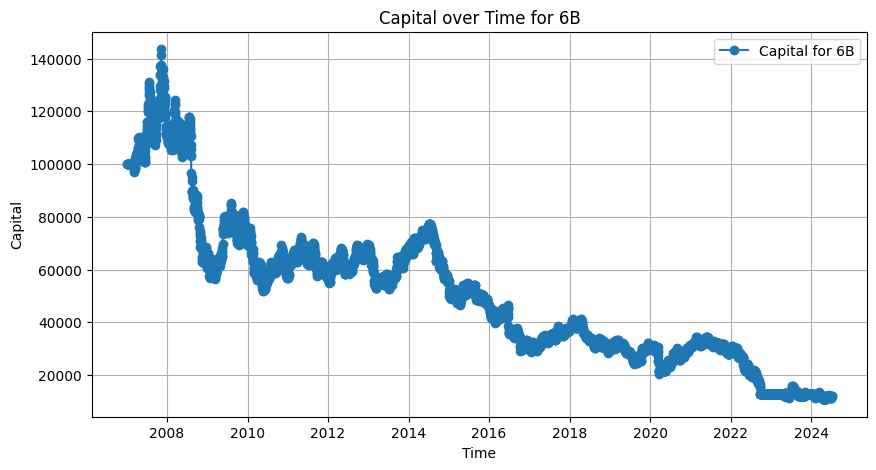

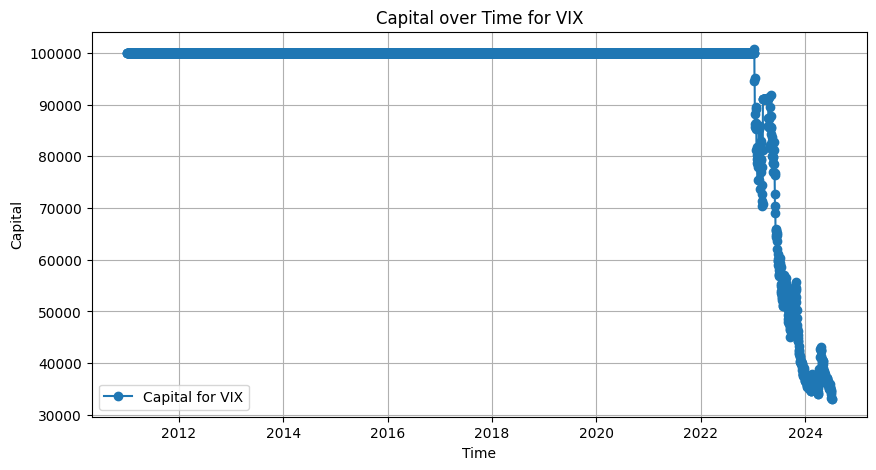

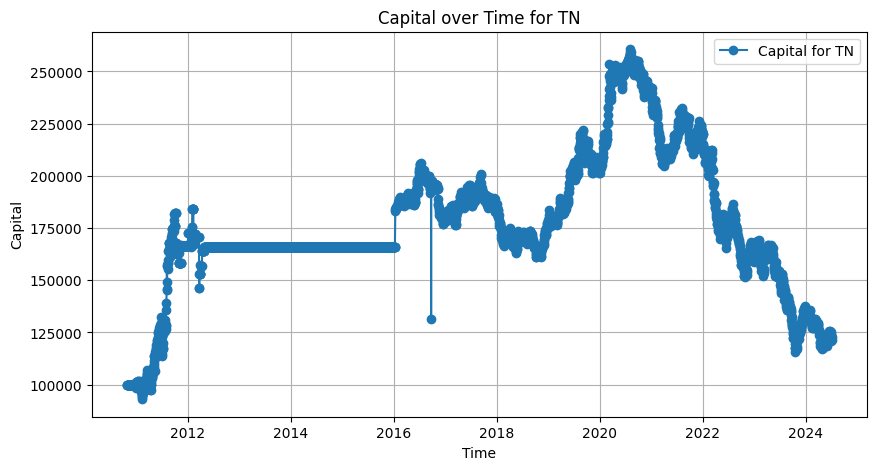

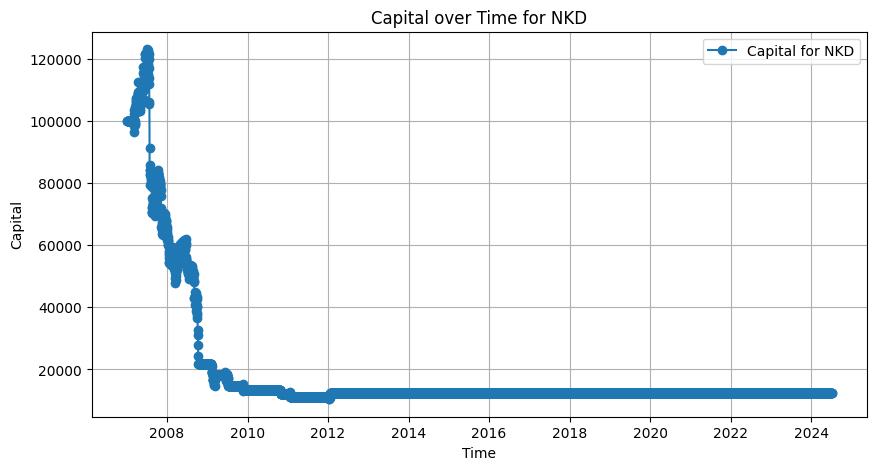

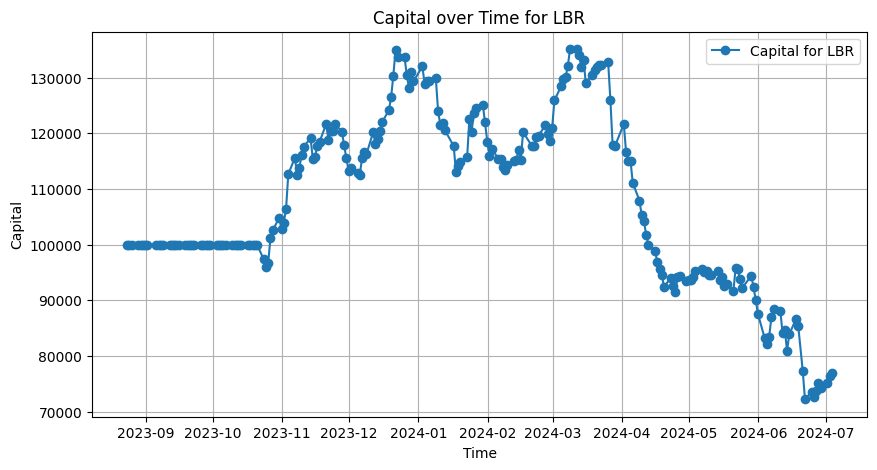

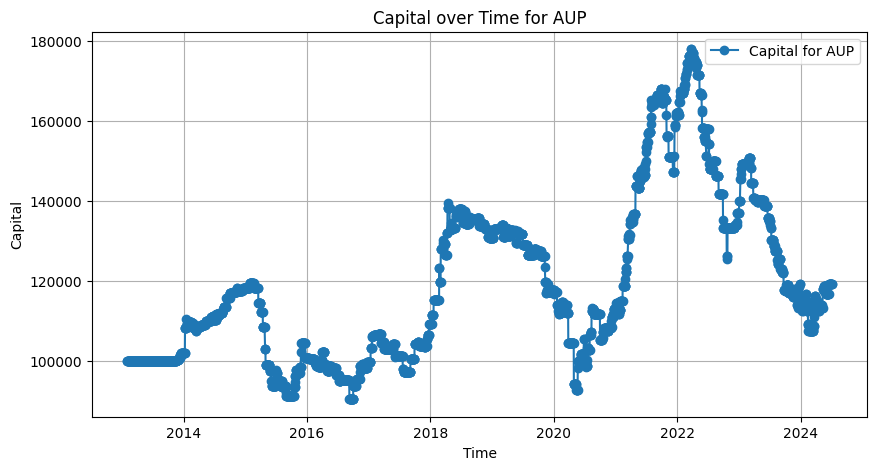

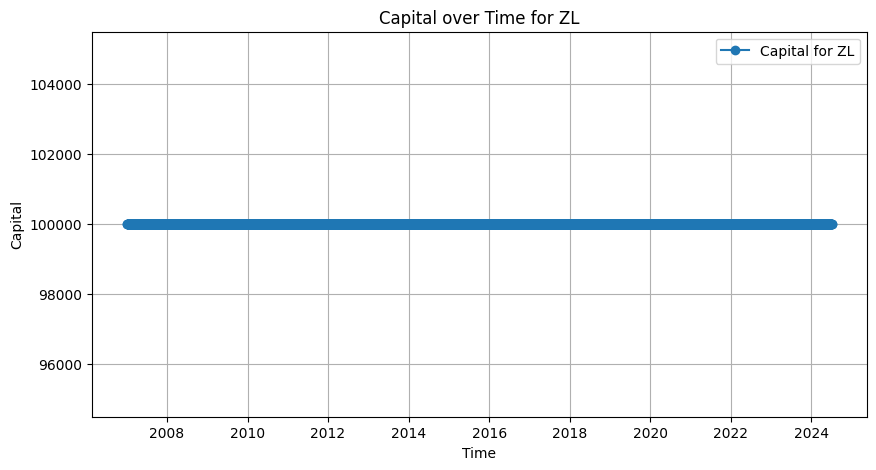

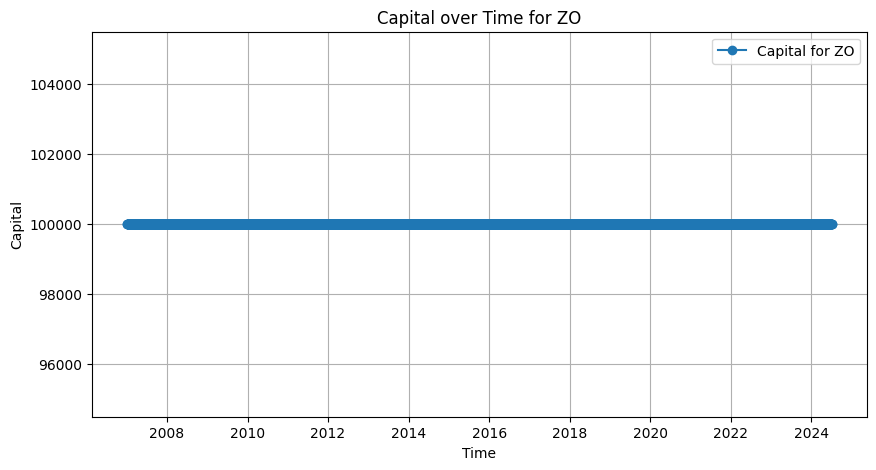

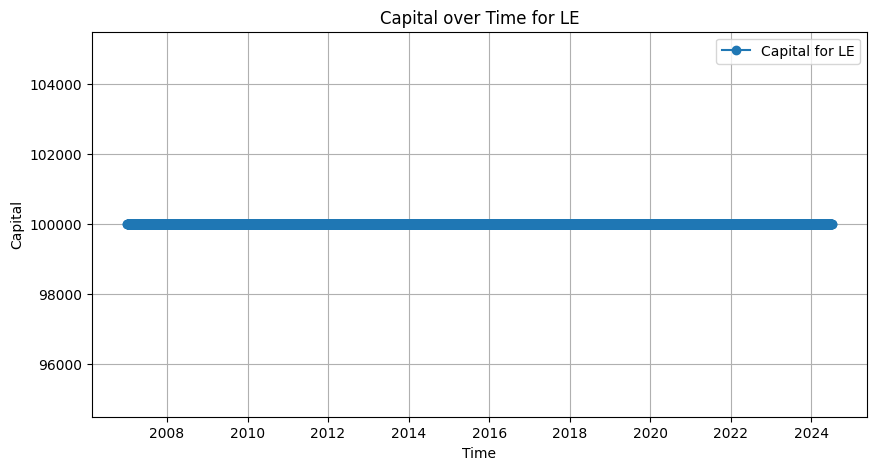

In [18]:
import matplotlib.pyplot as plt

def plot_capital_per_instrument_separately(results):
    symbols = results['symbol'].unique()
    for symbol in symbols:
        data = results[results['symbol'] == symbol]
        plt.figure(figsize=(10, 5))
        plt.plot(data['time'], data['capital'], label=f'Capital for {symbol}', marker='o', linestyle='-')
        plt.title(f'Capital over Time for {symbol}')
        plt.xlabel('Time')
        plt.ylabel('Capital')
        plt.grid(True)
        plt.legend()
        plt.show()

# Ejecutar la función de visualización
plot_capital_per_instrument_separately(results)


In [19]:
# Filtrar el DataFrame para el símbolo 'ES'
es_results = results[results['symbol'] == 'ES']

# Guardar el DataFrame filtrado a un archivo CSV
es_results.to_csv('ES_results.csv', index=False)

print("El archivo 'ES_results.csv' ha sido guardado exitosamente.")


El archivo 'ES_results.csv' ha sido guardado exitosamente.


## Strat 3 Risk adjusted cost and return

In [20]:
import numpy as np
import pandas as pd

def strat_3_performance_metrics(results, avg_round_trips, instruments, risk_free_rate=0, trading_days=252):
    performance_metrics = {}

    for symbol in results['symbol'].unique():
        symbol_data = results[results['symbol'] == symbol].copy()
        instrument = instruments[symbol]

        # Check if 'time' is in the index or as a column
        if 'time' in symbol_data.index.names:
            symbol_data['year'] = symbol_data.index.get_level_values('time').year
        elif 'time' in symbol_data.columns:
            symbol_data['year'] = pd.to_datetime(symbol_data['time']).dt.year
        else:
            raise ValueError("'time' information not found in results DataFrame")

        # Calculate daily returns
        daily_returns = symbol_data['capital'].pct_change().dropna()

        # Sharpe Ratio calculations
        annualized_return = (1 + daily_returns.mean()) ** trading_days - 1
        annualized_volatility = daily_returns.std() * np.sqrt(trading_days)
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else np.nan

        # Risk-adjusted cost calculations
        spread_cost_currency = instrument['multiplier'] * (instrument['spread'] / 2)
        total_cost_per_trade = spread_cost_currency + instrument['commission']
        
        avg_close_price = symbol_data['close_price'].mean()
        total_cost_per_trade_pct = total_cost_per_trade / (avg_close_price * instrument['multiplier'])
        
        risk_adjusted_cost_per_trade = total_cost_per_trade_pct / annualized_volatility if annualized_volatility != 0 else np.inf
        
        rolls_per_year = len(instrument['rolling_months'])
        risk_adjusted_holding_cost = risk_adjusted_cost_per_trade * rolls_per_year * 2

        # Yearly position and turnover calculations
        yearly_metrics = symbol_data.groupby('year').agg({
            'position_size': 'mean',
            'capital': lambda x: x.pct_change().std() * np.sqrt(trading_days)  # Yearly volatility
        })
        yearly_metrics['turnover'] = yearly_metrics.index.map(lambda year: avg_round_trips[symbol] / yearly_metrics.loc[year, 'position_size'] if yearly_metrics.loc[year, 'position_size'] != 0 else 0)
        
        avg_position = yearly_metrics['position_size'].mean()
        avg_turnover = yearly_metrics['turnover'].mean()
        
        risk_adjusted_transaction_cost = avg_turnover * risk_adjusted_cost_per_trade
        
        annual_risk_adjusted_cost = risk_adjusted_holding_cost + risk_adjusted_transaction_cost

        # Post-cost Sharpe Ratio (directly adjusted)
        post_cost_sharpe_ratio = sharpe_ratio - annual_risk_adjusted_cost

        performance_metrics[symbol] = {
            'annualized_return': annualized_return,
            'annualized_volatility': annualized_volatility,
            'sharpe_ratio': sharpe_ratio,
            'spread_cost_currency': spread_cost_currency,
            'total_cost_per_trade': total_cost_per_trade,
            'total_cost_per_trade_pct': total_cost_per_trade_pct,
            'risk_adjusted_cost_per_trade': risk_adjusted_cost_per_trade,
            'risk_adjusted_holding_cost': risk_adjusted_holding_cost,
            'avg_position': avg_position,
            'avg_turnover': avg_turnover,
            'risk_adjusted_transaction_cost': risk_adjusted_transaction_cost,
            'annual_risk_adjusted_cost': annual_risk_adjusted_cost,
            'post_cost_sharpe_ratio': post_cost_sharpe_ratio
        }

    return pd.DataFrame(performance_metrics).T

# Usage example:
# Assuming 'results', 'avg_round_trips', and 'instruments' are available from previous calculations
strat_3_metrics_df = strat_3_performance_metrics(results, avg_round_trips, instruments)

# Display the results
print(strat_3_metrics_df)

# You can also access specific metrics for each symbol, e.g.:
for symbol in strat_3_metrics_df.index:
    print(f"\nPerformance metrics for {symbol}:")
    print(f"Sharpe Ratio: {strat_3_metrics_df.loc[symbol, 'sharpe_ratio']:.4f}")
    print(f"Annual Risk-Adjusted Cost: {strat_3_metrics_df.loc[symbol, 'annual_risk_adjusted_cost']:.4f}")
    print(f"Post-Cost Sharpe Ratio: {strat_3_metrics_df.loc[symbol, 'post_cost_sharpe_ratio']:.4f}")

# To use a specific risk-free rate:
# strat_3_metrics_df_with_rf = strat_3_performance_metrics(results, avg_round_trips, instruments, risk_free_rate=0.02)

/tmp/ipykernel_86/587715121.py:49: RuntimeWarning: invalid value encountered in scalar multiply
  risk_adjusted_transaction_cost = avg_turnover * risk_adjusted_cost_per_trade
/tmp/ipykernel_86/587715121.py:49: RuntimeWarning: invalid value encountered in scalar multiply
  risk_adjusted_transaction_cost = avg_turnover * risk_adjusted_cost_per_trade
/tmp/ipykernel_86/587715121.py:49: RuntimeWarning: invalid value encountered in scalar multiply
  risk_adjusted_transaction_cost = avg_turnover * risk_adjusted_cost_per_trade
/tmp/ipykernel_86/587715121.py:49: RuntimeWarning: invalid value encountered in scalar multiply
  risk_adjusted_transaction_cost = avg_turnover * risk_adjusted_cost_per_trade
/tmp/ipykernel_86/587715121.py:49: RuntimeWarning: invalid value encountered in scalar multiply
  risk_adjusted_transaction_cost = avg_turnover * risk_adjusted_cost_per_trade


     annualized_return  annualized_volatility  sharpe_ratio  \
ES            0.231133               0.377060      0.612986   
MES           0.257922               0.301523      0.855398   
ZN            0.070485               0.221331      0.318461   
ZF            0.229727               0.792523      0.289868   
ZB            0.045635               0.246528      0.185112   
ZW            0.000000               0.000000           NaN   
CL            0.021452               0.116614      0.183957   
GC            0.100986               0.449086      0.224870   
HE            0.000000               0.000000           NaN   
GF            0.000000               0.000000           NaN   
ZS            0.000000               0.000000           NaN   
ZC            0.000000               0.000000           NaN   
NG           -0.022818               0.191092     -0.119411   
SI           -0.054132               0.132661     -0.408045   
HG           -0.087237               0.373137     -0.23

/tmp/ipykernel_86/587715121.py:49: RuntimeWarning: invalid value encountered in scalar multiply
  risk_adjusted_transaction_cost = avg_turnover * risk_adjusted_cost_per_trade
/tmp/ipykernel_86/587715121.py:49: RuntimeWarning: invalid value encountered in scalar multiply
  risk_adjusted_transaction_cost = avg_turnover * risk_adjusted_cost_per_trade
/tmp/ipykernel_86/587715121.py:49: RuntimeWarning: invalid value encountered in scalar multiply
  risk_adjusted_transaction_cost = avg_turnover * risk_adjusted_cost_per_trade


# Strat 4
Actualización de instruments dictionary, además de que corregí los multiplicadores de los instrumentos.

In [35]:
import pandas as pd
import numpy as np
from collections import defaultdict

class Portfolio:
    def __init__(self, initial_capital, target_risk, instruments):
        self.initial_capital = initial_capital
        self.current_capital = initial_capital
        self.target_risk = target_risk
        self.instruments = instruments
        self.positions = defaultdict(int)
        self.weights = defaultdict(float)
        self.idm = 1.0
        self.sharpe_ratio = 0.0
        
        print("Debugging Portfolio init:")
        print("self.instruments keys:", self.instruments.keys())
        print("First instrument in self.instruments:", next(iter(self.instruments.items())))

    def add_instrument(self, symbol):
        if symbol not in self.instruments:
            raise ValueError(f"Instrument {symbol} not found in the instruments dictionary")
        self.weights[symbol] = 0.0
        self.positions[symbol] = 0

    def update_weight(self, symbol, weight):
        self.weights[symbol] = weight

    def update_position(self, symbol, position):
        self.positions[symbol] = position

    def calculate_idm(self, realized_portfolio_risk):
        self.idm = self.target_risk / realized_portfolio_risk if realized_portfolio_risk > 0 else 1.0

    def get_sector_weights(self):
        sector_weights = defaultdict(float)
        for symbol, weight in self.weights.items():
            sector = self.instruments[symbol]['sector']
            sector_weights[sector] += weight
        return dict(sector_weights)

    def get_subsector_weights(self):
        subsector_weights = defaultdict(float)
        for symbol, weight in self.weights.items():
            subsector = self.instruments[symbol]['subsector']
            subsector_weights[subsector] += weight
        return dict(subsector_weights)


In [42]:
import pandas as pd
import numpy as np
from collections import defaultdict
import copy


def strategy_4(timeseries, instruments, initial_capital, target_risk=0.20):
    print("Debugging strategy_4:")
    print("instruments keys:", instruments.keys())
    print("First instrument:", next(iter(instruments.items())))
    # Step 1: Run Strategy 3 for each instrument individually
    individual_results = {}
    for symbol in timeseries.keys():
        individual_results[symbol] = run_strategy_3(timeseries[symbol], instruments[symbol], initial_capital, target_risk)

    # Step 2: Select the instrument with the highest post-cost Sharpe Ratio
    best_instrument = max(individual_results, key=lambda x: individual_results[x]['post_cost_sharpe_ratio'])
    current_portfolio = Portfolio(initial_capital, target_risk, instruments)
    print("After creating portfolio:")
    print("current_portfolio.instruments keys:", current_portfolio.instruments.keys())
    print("First instrument in portfolio:", next(iter(current_portfolio.instruments.items())))
    
    current_portfolio.add_instrument(best_instrument)
    current_portfolio.sharpe_ratio = individual_results[best_instrument]['post_cost_sharpe_ratio']

    remaining_instruments = set(timeseries.keys()) - {best_instrument}
    
    while remaining_instruments:
        best_new_instrument = None
        best_new_sharpe = current_portfolio.sharpe_ratio - 0.10  # Initialize with the minimum acceptable Sharpe Ratio

        for new_instrument in remaining_instruments:
            # Step 3a: Create trial portfolio
            trial_portfolio = create_trial_portfolio(current_portfolio, new_instrument)
            
            # Step 3b: Calculate weights and IDM
            calculate_weights_and_idm(trial_portfolio, timeseries)
            
            # Step 3c: Verify minimum capital
            if not has_minimum_capital(trial_portfolio):
                continue
            
            # Step 3d: Calculate expected post-cost Sharpe Ratio
            trial_sharpe = calculate_expected_sharpe_ratio(trial_portfolio)
            
            if trial_sharpe > best_new_sharpe:
                best_new_instrument = new_instrument
                best_new_sharpe = trial_sharpe

        # Step 4: Select instrument that doesn't decrease Sharpe Ratio by more than 0.10
        if best_new_instrument:
            current_portfolio.add_instrument(best_new_instrument)
            calculate_weights_and_idm(current_portfolio, timeseries)  # Recalculate IDM
            current_portfolio.sharpe_ratio = best_new_sharpe
            remaining_instruments.remove(best_new_instrument)
        else:
            break  # Stop if no instrument improves Sharpe Ratio within the acceptable range

    # Run final backtest with selected portfolio
    final_results = run_final_backtest(current_portfolio, timeseries)
    
    return final_results, current_portfolio

def run_strategy_3(data, instrument, capital, target_risk):
    results = []
    yearly_round_trips = defaultdict(int)
    contracts_opened = 0
    
    if 'day_of_week' not in data.columns:
        data['day_of_week'] = data.index.get_level_values('time').map(lambda x: x.weekday())

    prev_positions = 0
    last_friday_position = 0
    sample_count = 0
    multiplier = instrument['multiplier']
    max_capital = capital

    for idx, row in data.iterrows():
        current_year = idx[1].year  # Cambiado de idx.year a idx[1].year
        sample_count += 1
        target_risk_in_usd = capital * target_risk
        contract_risk_currency = row['combined_std'] * row['close'] * multiplier
        position_size_float = target_risk_in_usd / contract_risk_currency if contract_risk_currency > 0 else 0
        new_position = np.round(position_size_float)

        if sample_count <= 40:  # Warmup period
            results.append({
                'time': idx[1],  # Cambiado de idx a idx[1]
                'position_size': 0,
                'position_size_float': 0,
                'capital': capital,
                'drawdown': max_capital - capital,
                'target_risk_in_usd': 0,
                'combined_std': row['combined_std'],
                'contract_risk_currency': contract_risk_currency,
                'currency_return': row['currency_return'],
                'close_price': row['close']
            })
            continue

        if row['day_of_week'] == 4:
            last_friday_position = new_position
        
        if row['day_of_week'] == 0 and last_friday_position is not None:
            position_change = new_position - prev_positions
            if position_change > 0:
                contracts_opened += position_change
            elif position_change < 0:
                closed_contracts = min(abs(position_change), contracts_opened)
                yearly_round_trips[current_year] += closed_contracts
                contracts_opened -= closed_contracts

            prev_positions = new_position

        daily_return = row['currency_return'] * prev_positions
        capital += daily_return
        max_capital = max(max_capital, capital)
        drawdown = max_capital - capital
        
        results.append({
            'time': idx[1],  # Cambiado de idx a idx[1]
            'position_size': prev_positions,
            'position_size_float': position_size_float,
            'capital': capital,
            'drawdown': drawdown,
            'target_risk_in_usd': target_risk_in_usd,
            'combined_std': row['combined_std'],
            'contract_risk_currency': contract_risk_currency,
            'currency_return': row['currency_return'],
            'close_price': row['close']
        })

    results_df = pd.DataFrame(results)
        
    # Calculate average round trips per year
    total_years = len(yearly_round_trips)
    avg_round_trips = sum(yearly_round_trips.values()) / total_years if total_years > 0 else 0

    # Calculate performance metrics
    daily_returns = results_df['capital'].pct_change().dropna()
    annualized_return = (1 + daily_returns.mean()) ** 252 - 1
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0

    # Calculate costs
    spread_cost_currency = instrument['multiplier'] * (instrument['spread'] / 2)
    total_cost_per_trade = spread_cost_currency + instrument['commission']
    avg_close_price = results_df['close_price'].mean()
    total_cost_per_trade_pct = total_cost_per_trade / (avg_close_price * instrument['multiplier'])
    risk_adjusted_cost_per_trade = total_cost_per_trade_pct / annualized_volatility if annualized_volatility != 0 else np.inf
    rolls_per_year = len(instrument['rolling_months'])
    risk_adjusted_holding_cost = risk_adjusted_cost_per_trade * rolls_per_year * 2
    avg_position = results_df['position_size'].mean()
    avg_turnover = avg_round_trips / avg_position if avg_position != 0 else 0
    risk_adjusted_transaction_cost = avg_turnover * risk_adjusted_cost_per_trade
    annual_risk_adjusted_cost = risk_adjusted_holding_cost + risk_adjusted_transaction_cost
    post_cost_sharpe_ratio = sharpe_ratio - annual_risk_adjusted_cost

    return {
        'results': results_df,
        'avg_round_trips': avg_round_trips,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'annual_risk_adjusted_cost': annual_risk_adjusted_cost,
        'post_cost_sharpe_ratio': post_cost_sharpe_ratio
    }

def create_trial_portfolio(current_portfolio, new_instrument):
    trial_portfolio = copy.deepcopy(current_portfolio)
    trial_portfolio.add_instrument(new_instrument)
    print("Debugging create_trial_portfolio:")
    print("trial_portfolio.instruments keys:", trial_portfolio.instruments.keys())
    print("First instrument in trial_portfolio:", next(iter(trial_portfolio.instruments.items())))
    
    return trial_portfolio

def calculate_weights_and_idm(portfolio, timeseries):
    print("Debugging calculate_weights_and_idm:")
    print("portfolio.instruments keys:", portfolio.instruments.keys())
    print("First instrument:", next(iter(portfolio.instruments.items())))
    
    # Calculate sector weights
    sector_weights = defaultdict(float)
    for symbol, instrument_data in portfolio.instruments.items():
        print(f"Processing symbol: {symbol}")
        print(f"Instrument data: {instrument_data}")
        if symbol == 'USDMXN':
            print(f"Skipping USDMXN")
            continue
        if 'sector' not in instrument_data:
            print(f"Warning: 'sector' not found for {symbol}")
            continue
        sector = instrument_data['sector']
        sector_weights[sector] += 1
    
    print("Sector weights:", dict(sector_weights))
    
    # Normalize sector weights
    total_sectors = len(sector_weights)
    for sector in sector_weights:
        sector_weights[sector] /= total_sectors
    
    # Calculate instrument weights
    for symbol, instrument_data in portfolio.instruments.items():
        if symbol == 'USDMXN':
            continue
        if 'sector' not in instrument_data or 'subsector' not in instrument_data:
            print(f"Warning: 'sector' or 'subsector' not found for {symbol}")
            continue
        sector = instrument_data['sector']
        subsector = instrument_data['subsector']

        # Count the instruments in the same subsector
        subsector_count = sum(1 for s, i in portfolio.instruments.items() 
                              if s != 'USDMXN' and 'sector' in i and 'subsector' in i and
                              i['sector'] == sector and i['subsector'] == subsector)
        
        # Assign weight
        portfolio.weights[symbol] = sector_weights[sector] / subsector_count
    
    print("Instrument weights:", dict(portfolio.weights))
    
    # Calculate IDM
    returns = {}
    for symbol in portfolio.instruments:
        if symbol == 'USDMXN' or symbol not in timeseries:
            continue
        returns[symbol] = timeseries[symbol]['currency_return'] * portfolio.weights[symbol]
    
    returns_df = pd.DataFrame(returns)
    correlation_matrix = returns_df.corr()
    
    # Calculate IDM based on average correlation
    avg_correlation = (correlation_matrix.sum().sum() - len(correlation_matrix)) / (len(correlation_matrix)**2 - len(correlation_matrix))
    portfolio.idm = 1 / np.sqrt(avg_correlation) if avg_correlation > 0 else 1.0

    print(f"Calculated IDM: {portfolio.idm}")

    return portfolio

def has_minimum_capital(portfolio):
    total_required_capital = 0
    
    for symbol, instrument_data in portfolio.instruments.items():
        if symbol == 'USDMXN':
            continue
        if 'multiplier' not in instrument_data:
            print(f"Warning: 'multiplier' not found for {symbol}")
            continue
        
        if symbol not in timeseries:
            print(f"Warning: {symbol} not found in timeseries")
            continue
        
        last_price = timeseries[symbol]['close'].iloc[-1]
        annualized_std_dev = timeseries[symbol]['combined_std'].iloc[-1] * np.sqrt(252)
        
        if symbol not in portfolio.weights:
            print(f"Warning: {symbol} not found in portfolio weights")
            continue
        
        capital_required = (4 * instrument_data['multiplier'] * last_price * annualized_std_dev) / (portfolio.idm * portfolio.weights[symbol] * portfolio.target_risk)
        
        total_required_capital += capital_required
    
    print(f"Total required capital: {total_required_capital}")
    print(f"Current capital: {portfolio.current_capital}")
    
    return portfolio.current_capital >= total_required_capital

def calculate_expected_sharpe_ratio(portfolio):
    weighted_sharpe = 0
    for symbol, weight in portfolio.weights.items():
        individual_sharpe = portfolio.individual_results[symbol]['post_cost_sharpe_ratio']
        weighted_sharpe += weight * individual_sharpe
    
    expected_sharpe = weighted_sharpe * portfolio.idm
    return expected_sharpe

def run_final_backtest(portfolio, timeseries):
    results = []
    portfolio.current_capital = portfolio.initial_capital
    max_capital = portfolio.initial_capital

    # Align all timeseries to the same date range
    start_dates = [ts.index.get_level_values('time')[0] for ts in timeseries.values() if not ts.empty]
    end_dates = [ts.index.get_level_values('time')[-1] for ts in timeseries.values() if not ts.empty]
    start_date = max(start_dates)
    end_date = min(end_dates)
    
    for date in pd.date_range(start_date, end_date, freq='D'):
        daily_pnl = 0
        
        # Rebalance on Mondays
        if date.weekday() == 0:
            calculate_weights_and_idm(portfolio, timeseries)
        
        for symbol, instrument_data in timeseries.items():
            if symbol == 'USDMXN':
                continue
            if date in instrument_data.index.get_level_values('time'):
                row = instrument_data.loc[instrument_data.index.get_level_values('time') == date].iloc[0]
                weight = portfolio.weights[symbol]
                target_risk_in_usd = portfolio.current_capital * portfolio.target_risk * weight * portfolio.idm
                contract_risk_currency = row['combined_std'] * row['close'] * portfolio.instruments[symbol]['multiplier']
                position_size_float = target_risk_in_usd / contract_risk_currency if contract_risk_currency > 0 else 0
                new_position = np.round(position_size_float)
                
                # Calculate P&L
                daily_pnl += row['currency_return'] * new_position
                
                portfolio.positions[symbol] = new_position
        
        portfolio.current_capital += daily_pnl
        max_capital = max(max_capital, portfolio.current_capital)
        drawdown = (max_capital - portfolio.current_capital) / max_capital
        
        results.append({
            'date': date,
            'capital': portfolio.current_capital,
            'drawdown': drawdown,
            'daily_pnl': daily_pnl
        })
    
    results_df = pd.DataFrame(results).set_index('date')
    
    # Calculate performance metrics
    returns = results_df['capital'].pct_change().dropna()
    annualized_return = (1 + returns.mean()) ** 252 - 1
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
    max_drawdown = results_df['drawdown'].max()
    
    return {
        'results': results_df,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }

Debugging strategy_4:
instruments keys: dict_keys(['ES', 'MES', 'ZN', 'ZF', 'ZB', 'ZW', 'CL', 'GC', 'HE', 'GF', 'ZS', 'ZC', 'NG', 'SI', 'HG', 'NQ', '6E', '6J', '6B', 'VIX', 'TN', 'NKD', 'LBR', 'AUP', 'ZL', 'ZO', 'LE', 'USDMXN'])
First instrument: ('ES', {'multiplier': 50, 'tick_value': 0.25, 'minimum_fluctuation': 12.5, 'spread': 0.25, 'commission': 2.5, 'rolling_months': [3, 6, 9, 12], 'subscription_type': 'Future', 'subscription_details': 'ES', 'resolution': 4, 'sector': 'equity', 'subsector': 'us', 'multiply_close': False})
Debugging Portfolio init:
self.instruments keys: dict_keys(['ES', 'MES', 'ZN', 'ZF', 'ZB', 'ZW', 'CL', 'GC', 'HE', 'GF', 'ZS', 'ZC', 'NG', 'SI', 'HG', 'NQ', '6E', '6J', '6B', 'VIX', 'TN', 'NKD', 'LBR', 'AUP', 'ZL', 'ZO', 'LE', 'USDMXN'])
First instrument in self.instruments: ('ES', {'multiplier': 50, 'tick_value': 0.25, 'minimum_fluctuation': 12.5, 'spread': 0.25, 'commission': 2.5, 'rolling_months': [3, 6, 9, 12], 'subscription_type': 'Future', 'subscription_det

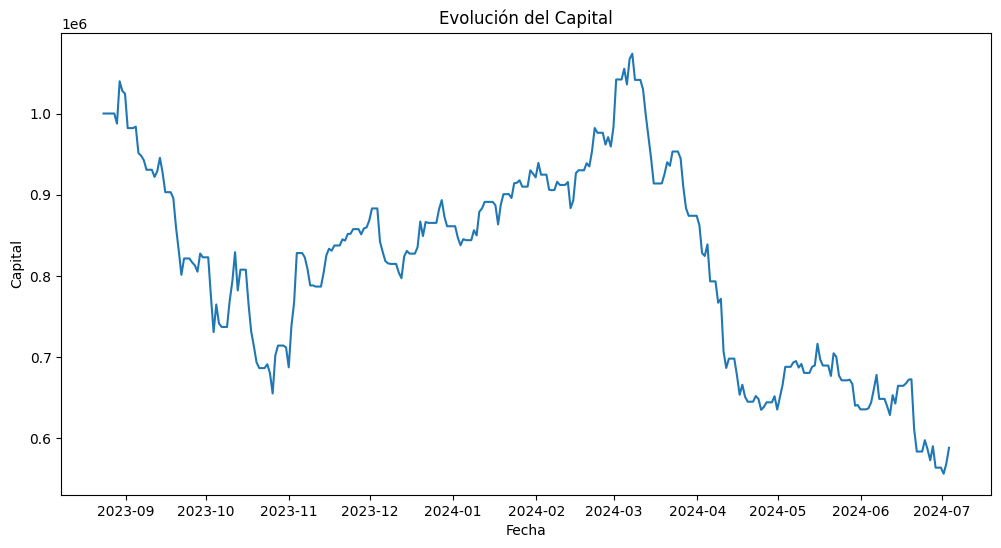

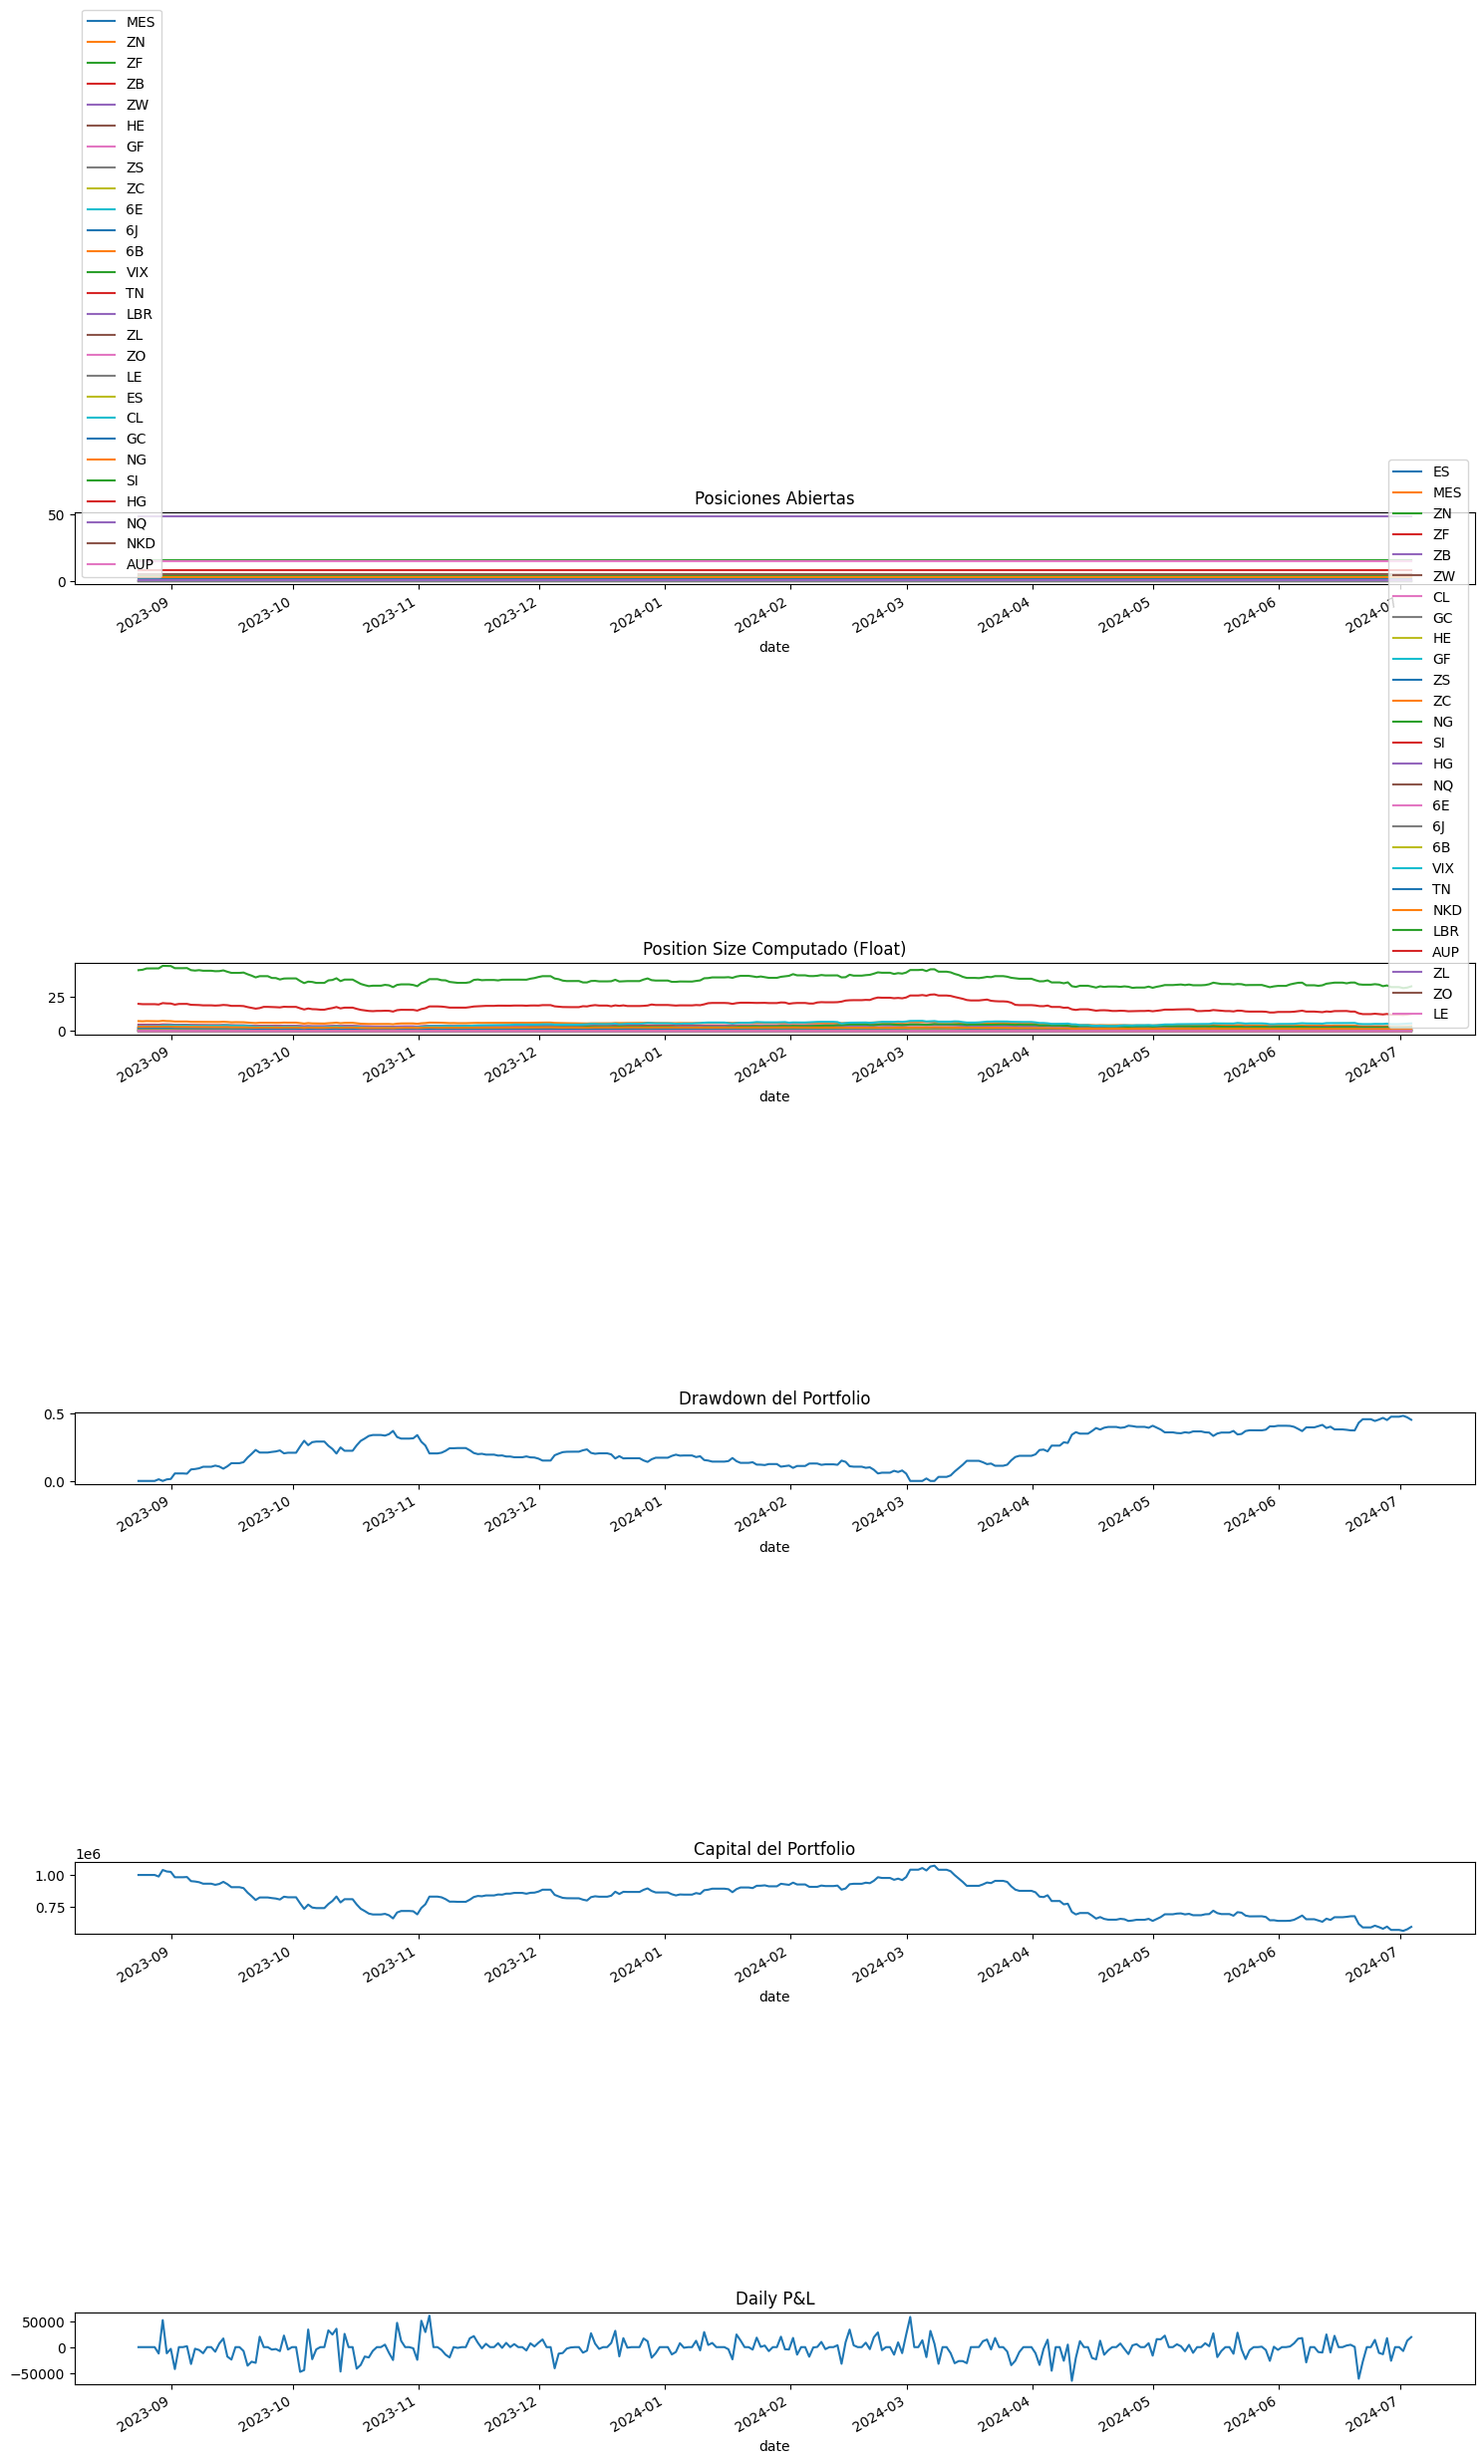

Capital final: $588,372.63
Drawdown máximo: 48.17%
Tamaño de posición promedio por instrumento:
MES    16.0
ZN      5.0
ZF     16.0
ZB      5.0
ZW      0.0
HE      0.0
GF      0.0
ZS      0.0
ZC      0.0
6E      2.0
6J      0.0
6B      4.0
VIX     4.0
TN      3.0
LBR    49.0
ZL      0.0
ZO      0.0
LE      0.0
ES      3.0
CL      1.0
GC      2.0
NG      3.0
SI      1.0
HG      8.0
NQ      1.0
NKD     5.0
AUP    15.0
dtype: float64

Weights por sector:
{'equity': 1.0, 'bonds': 1.5, 'agriculture': 1.4999999999999998, 'livestock': 0.75, 'currency': 0.375, 'volatility': 0.125, 'energy': 0.25, 'metals': 1.0}

Weights por subsector:
{'us': 0.5, 'long_term': 0.5, 'short_term': 0.5, 'medium_term': 0.5, 'grains': 0.75, 'hogs': 0.375, 'cattle': 0.375, 'major': 0.375, 'index': 0.125, 'lumber': 0.75, 'fossil': 0.25, 'precious': 0.5, 'industrial': 0.5, 'international': 0.5}

Weights por instrumento:
defaultdict(<class 'float'>, {'MES': 0.16666666666666666, 'ZN': 0.25, 'ZF': 0.5, 'ZB': 0.5, 'ZW': 0.

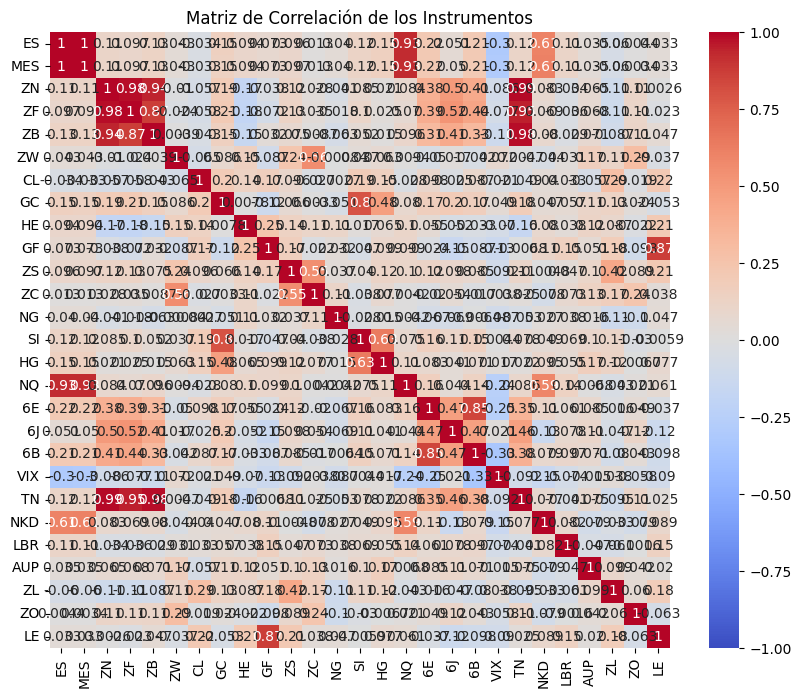

In [46]:

# Ejecutar Strategy 4
final_results, final_portfolio = strategy_4(timeseries, instruments, initial_capital=1000000, target_risk=0.20)


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Post-cost Sharpe Ratio del portfolio
print(f"Post-cost Sharpe Ratio del portfolio: {final_results['sharpe_ratio']:.4f}")

# 2. Gráficos del backtest
plt.figure(figsize=(12, 6))
plt.plot(final_results['results'].index, final_results['results']['capital'])
plt.title('Evolución del Capital')
plt.xlabel('Fecha')
plt.ylabel('Capital')
plt.show()

# 3. Serie temporal con posiciones abiertas, position size y drawdown
positions_df = pd.DataFrame(final_portfolio.positions, index=final_results['results'].index)

# Crear un DataFrame con las fechas del backtest
date_range = pd.to_datetime(final_results['results'].index)
position_size_df = pd.DataFrame(index=date_range)

# Calcular position size para cada símbolo
for symbol in final_portfolio.instruments:
    if symbol == 'USDMXN':
        continue
    symbol_timeseries = timeseries[symbol].reset_index(level='symbol')
    symbol_timeseries.index = pd.to_datetime(symbol_timeseries.index)
    symbol_timeseries = symbol_timeseries.reindex(date_range, method='ffill')
    position_size = (final_results['results']['capital'] * final_portfolio.weights[symbol] * final_portfolio.idm /
                     (symbol_timeseries['close'] * instruments[symbol]['multiplier']))
    position_size_df[symbol] = position_size

plt.figure(figsize=(15, 20))
plt.subplot(5, 1, 1)
positions_df.plot(ax=plt.gca())
plt.title('Posiciones Abiertas')
plt.subplot(5, 1, 2)
position_size_df.plot(ax=plt.gca())
plt.title('Position Size Computado (Float)')
plt.subplot(5, 1, 3)
final_results['results']['drawdown'].plot(ax=plt.gca())
plt.title('Drawdown del Portfolio')
plt.subplot(5, 1, 4)
final_results['results']['capital'].plot(ax=plt.gca())
plt.title('Capital del Portfolio')
plt.subplot(5, 1, 5)
final_results['results']['daily_pnl'].plot(ax=plt.gca())
plt.title('Daily P&L')
plt.tight_layout()
plt.show()

# 4. Capital final, turnover promedio y drawdown máximo
print(f"Capital final: ${final_results['results']['capital'].iloc[-1]:,.2f}")
print(f"Drawdown máximo: {final_results['max_drawdown']:.2%}")

# 5. Tamaño de posición promedio por instrumento
avg_position_size = positions_df.mean()
print("Tamaño de posición promedio por instrumento:")
print(avg_position_size)

# 6. Weights por sector
sector_weights = final_portfolio.get_sector_weights()
print("\nWeights por sector:")
print(sector_weights)

# 7. Weights por subsector
subsector_weights = final_portfolio.get_subsector_weights()
print("\nWeights por subsector:")
print(subsector_weights)

# 8. Weights por instrumento
print("\nWeights por instrumento:")
print(final_portfolio.weights)

# 9. IDM
print(f"\nIDM: {final_portfolio.idm:.4f}")

# 10. Retorno anualizado del portfolio
print(f"Retorno anualizado del portfolio: {final_results['annualized_return']:.2%}")

# 11. Volatilidad anualizada del portfolio
print(f"Volatilidad anualizada del portfolio: {final_results['annualized_volatility']:.2%}")

# 12. Costos totales y costos como porcentaje del retorno
# Nota: Esta información no está directamente disponible en los resultados proporcionados.
# Necesitarías calcular estos costos durante el backtest o añadirlos a los resultados finales.

# 13. Lista de los instrumentos en el portfolio
print("\nInstrumentos en el portfolio:")
print(list(final_portfolio.instruments.keys()))

# Visualización adicional: Heatmap de correlaciones
returns = final_results['results']['capital'].pct_change().dropna()
instrument_returns = pd.DataFrame()

for symbol in final_portfolio.instruments:
    if symbol == 'USDMXN':
        continue
    symbol_returns = timeseries[symbol]['currency_return'].reset_index(level='symbol')
    symbol_returns.index = pd.to_datetime(symbol_returns.index)
    symbol_returns = symbol_returns.reindex(returns.index, method='ffill')
    instrument_returns[symbol] = symbol_returns['currency_return']

correlation_matrix = instrument_returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación de los Instrumentos')
plt.show()